## Demand Forecasting Pipeline


In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 
from scipy import stats
import time


#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

c:\Users\Nourhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    # Filter out zero actual values to avoid division by zero
    mask = actual != 0
    actual, pred = actual[mask], pred[mask]
    return np.mean(np.abs((actual - pred) / actual)) * 100

### Reading in Data


In [3]:
df = pd.read_csv('quick_data_mapped.csv')
df.columns = df.columns.str.lower()
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


In [4]:
min(df['timestamp']), max(df['timestamp'])

(Timestamp('2023-12-01 00:00:00'), Timestamp('2023-12-31 23:40:00'))

In [5]:
df.head()

,segment,timestamp,target
0,merchant_1,2023-12-01,1
1,merchant_2,2023-12-01,2
2,merchant_3,2023-12-01,4
3,merchant_4,2023-12-01,2
4,merchant_5,2023-12-01,1


Let's aggregate the dataset to the "family" and "sales" daily level so that we can have high volume metrics for demand forecasting throughout the country. The line of code below can also be done in SQL.
<i>select date,
        family, 
        sum(sales)
from df
group by date, family
</i>

In [6]:
agg_df = df.groupby(['timestamp', 'segment']).agg({'target': 'sum'}).reset_index().sort_values(['segment', 'timestamp']) #groups the data frame
#(where segment corresponds to merchant, timestamp to date, and target to orders


In [7]:
agg_df.head()

,timestamp,segment,target
0,2023-12-01 00:00:00,merchant_1,1
7,2023-12-01 00:20:00,merchant_1,2
14,2023-12-01 00:40:00,merchant_1,3
22,2023-12-01 01:00:00,merchant_1,2
28,2023-12-01 01:20:00,merchant_1,3


In [8]:
agg_df.tail()

,timestamp,segment,target
21067,2023-12-31 22:20:00,merchant_9,4
21074,2023-12-31 22:40:00,merchant_9,2
21081,2023-12-31 23:00:00,merchant_9,4
21087,2023-12-31 23:20:00,merchant_9,2
21095,2023-12-31 23:40:00,merchant_9,2


In [9]:
total_orders_df = agg_df.pivot(index='timestamp', columns='segment', values='target')
total_orders_df.tail()

segment,merchant_1,merchant_10,merchant_2,merchant_3,merchant_4,merchant_5,merchant_6,merchant_7,merchant_8,merchant_9
timestamp,,,,,,,,,,
2023-12-31 22:20:00,NaN,4.00,3.00,NaN,4.00,10.00,NaN,3.00,NaN,4.00
2023-12-31 22:40:00,NaN,3.00,2.00,2.00,6.00,10.00,NaN,2.00,NaN,2.00
2023-12-31 23:00:00,NaN,5.00,2.00,3.00,NaN,10.00,2.00,1.00,NaN,4.00
2023-12-31 23:20:00,NaN,3.00,3.00,NaN,3.00,6.00,NaN,NaN,1.00,2.00
2023-12-31 23:40:00,NaN,NaN,4.00,4.00,7.00,9.00,1.00,2.00,5.00,2.00


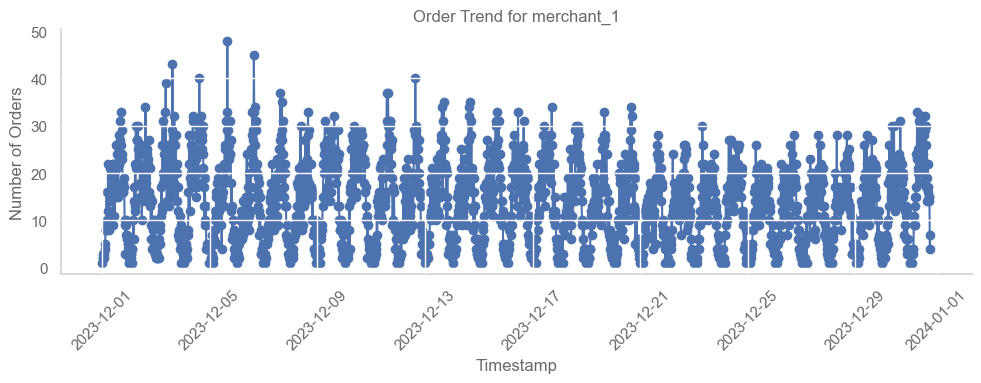

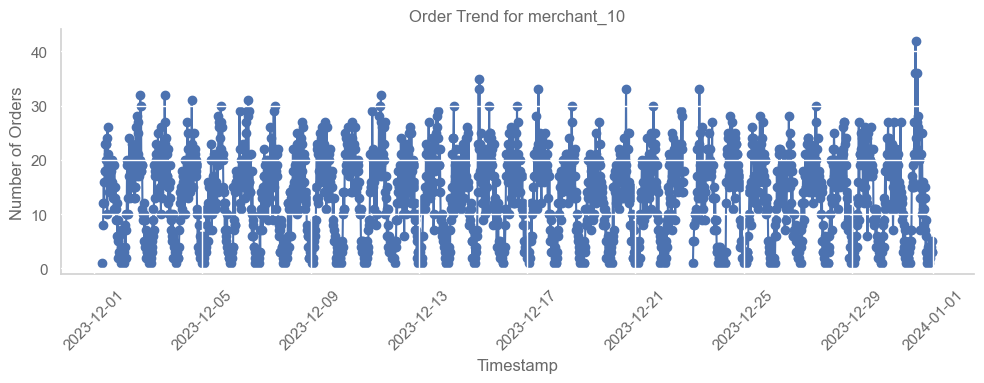

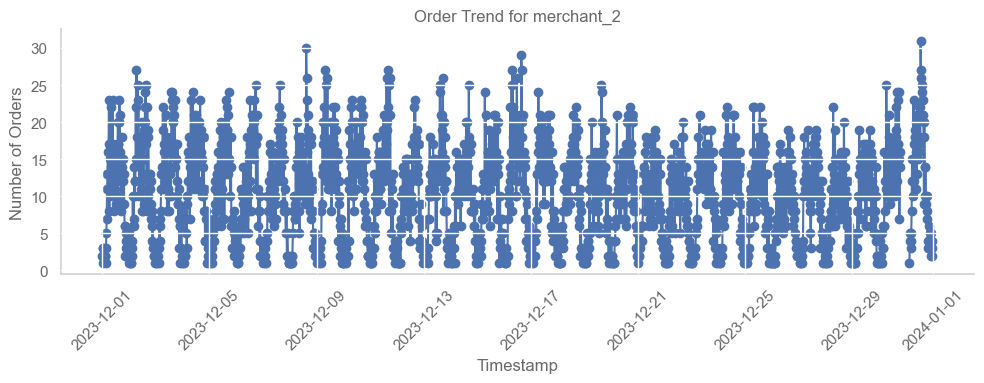

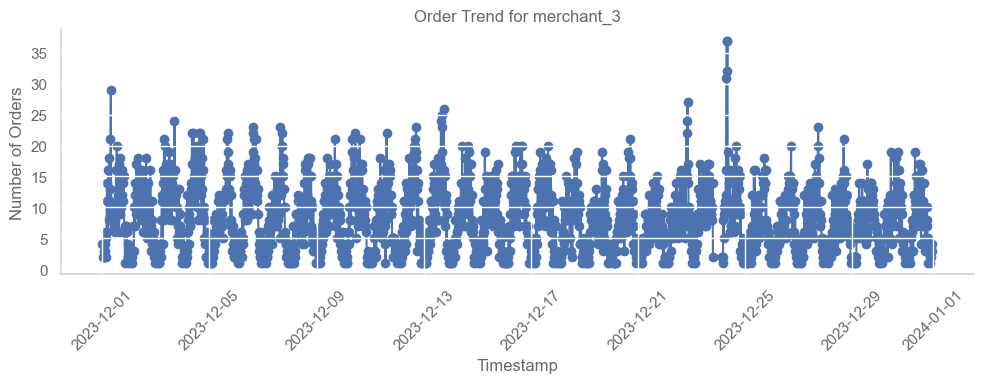

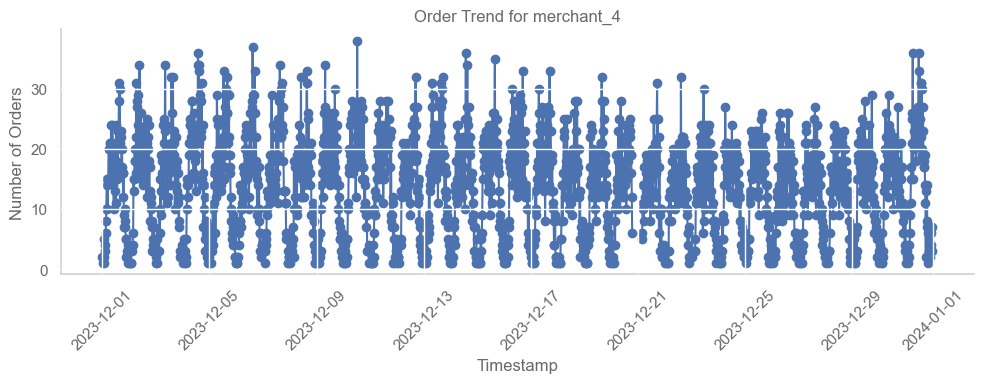

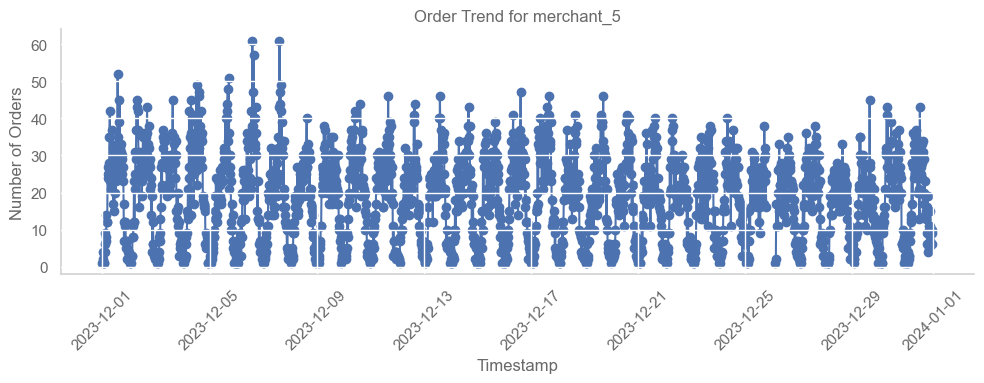

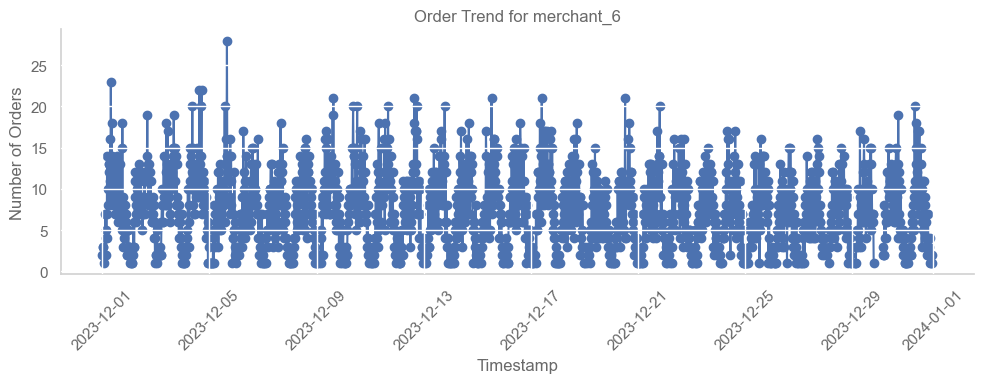

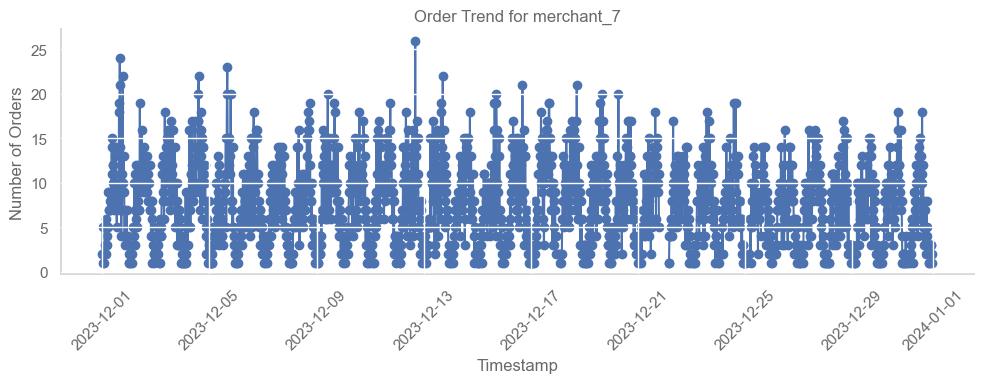

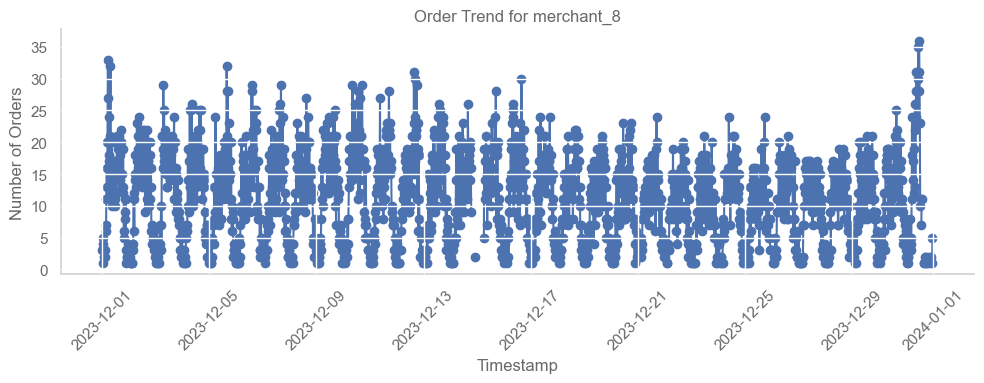

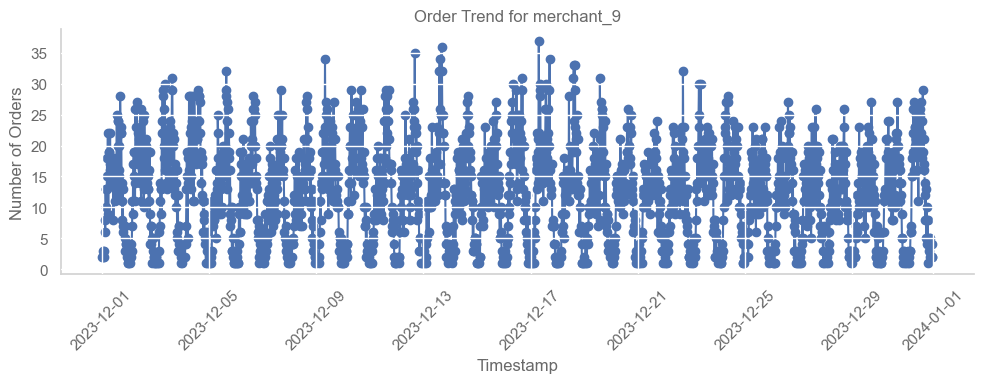

In [10]:
for column in total_orders_df.columns:
    plt.figure(figsize=(10, 4))  
    plt.plot(total_orders_df.index, total_orders_df[column], marker='o', linestyle='-')  
    plt.title(f"Order Trend for {column}")
    plt.xlabel('Timestamp')
    plt.ylabel('Number of Orders')
    plt.grid(True)  
    plt.xticks(rotation=45)  
    plt.tight_layout()  
    plt.show()

In [11]:
total_orders_df = total_orders_df[total_orders_df.index >= '2023-12-01']


In [12]:
missing_data(total_orders_df)

,Total,Percent,Types
segment,,,
merchant_1,71,3.18,float64
merchant_10,106,4.75,float64
merchant_2,110,4.93,float64
merchant_3,122,5.47,float64
merchant_4,119,5.33,float64
merchant_5,82,3.67,float64
merchant_6,177,7.93,float64
merchant_7,160,7.17,float64
merchant_8,136,6.09,float64


In [13]:
total_orders_df.fillna(0, inplace=True) #filling nan values with zeros

# or filling NaN values with the mean of each column
#total_orders_df.fillna(total_orders_df.mean(), inplace=True)

missing_data(total_orders_df)

,Total,Percent,Types
segment,,,
merchant_1,0,0.00,float64
merchant_10,0,0.00,float64
merchant_2,0,0.00,float64
merchant_3,0,0.00,float64
merchant_4,0,0.00,float64
merchant_5,0,0.00,float64
merchant_6,0,0.00,float64
merchant_7,0,0.00,float64
merchant_8,0,0.00,float64


### HYPERPARAMETER TUNING AND BACKTESTING PIPELINE

Ranges give on Prophet's documentation

1. changepoint_prior_scale [0.001, 0.5] 
2. seasonality_prior_scale [0.01, 10]
3. holidays_prior_scale [0.01, 10] 
4. seasonality_mode ['additive', 'multiplicative'].
5. changepoint_range [0.5, 0.95]

https://facebook.github.io/prophet/docs/diagnostics.html

In [21]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [22]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

#seasonality_mode_options = ['additive', 'multiplicative']
#changepoint_range_range = list(np.linspace(0.5, 0.95, num=5))

In [23]:
start_time = time.time()

dicts = {}

for feature in total_orders_df.columns:
  
    category_df = total_orders_df[feature].copy().reset_index()
    category_df.columns = ["ds", "y"]

    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range }
        #'holidays_prior_scale': holidays_prior_scale_range,
        #'seasonality_mode': seasonality_mode_options,
        #'changepoint_range': changepoint_range_range,

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    #mapes = [] 
    rmses = []
    maes = []

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(category_df)  # Fit model with given params
        df_cv = cross_validation(m, initial="10 days", period="7 days", horizon = "1 days") #took parallel out
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        #mapes.append(df_p["mape"].values[0])
        rmses.append(df_p["rmse"].values[0])
        maes.append(df_p["mae"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    #tuning_results["mape"] = mapes
    tuning_results["rmse"] = rmses
    tuning_results["mae"] = maes
    
    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("rmse").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    dicts[feature] = params_dict

print("--- %s seconds ---" % (time.time() - start_time)) #about 18 minutes

10:12:12 - cmdstanpy - INFO - Chain [1] start processing
10:12:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:12 - cmdstanpy - INFO - Chain [1] start processing
10:12:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.00it/s]10:12:12 - cmdstanpy - INFO - Chain [1] start processing
10:12:12 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.68it/s]10:12:13 - cmdstanpy - INFO - Chain [1] start processing
10:12:13 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.38it/s]
10:12:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 28.33  5.32 4.14   0.31   0.55      0.73


10:12:13 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:13 - cmdstanpy - INFO - Chain [1] start processing
10:12:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.63it/s]10:12:13 - cmdstanpy - INFO - Chain [1] start processing
10:12:14 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.80it/s]10:12:14 - cmdstanpy - INFO - Chain [1] start processing
10:12:14 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.70  5.17 3.89   0.28   0.52      0.72


10:12:14 - cmdstanpy - INFO - Chain [1] start processing
10:12:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:14 - cmdstanpy - INFO - Chain [1] start processing
10:12:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.47it/s]10:12:15 - cmdstanpy - INFO - Chain [1] start processing
10:12:15 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.86it/s]10:12:15 - cmdstanpy - INFO - Chain [1] start processing
10:12:15 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.75it/s]
10:12:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.54  5.15 3.88   0.27   0.52      0.72


10:12:15 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:16 - cmdstanpy - INFO - Chain [1] start processing
10:12:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.45it/s]10:12:16 - cmdstanpy - INFO - Chain [1] start processing
10:12:16 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.68it/s]10:12:16 - cmdstanpy - INFO - Chain [1] start processing
10:12:16 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.40it/s]
10:12:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.52  5.15 3.89   0.27   0.52      0.71


10:12:17 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:17 - cmdstanpy - INFO - Chain [1] start processing
10:12:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.36it/s]10:12:17 - cmdstanpy - INFO - Chain [1] start processing
10:12:17 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  4.12it/s]10:12:17 - cmdstanpy - INFO - Chain [1] start processing
10:12:18 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.22it/s]
10:12:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.57  5.15 3.90   0.27   0.52      0.72


10:12:18 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:18 - cmdstanpy - INFO - Chain [1] start processing
10:12:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.90it/s]10:12:18 - cmdstanpy - INFO - Chain [1] start processing
10:12:18 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.51it/s]10:12:19 - cmdstanpy - INFO - Chain [1] start processing
10:12:19 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.27it/s]
10:12:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 27.99  5.29 4.03   0.28   0.54      0.73


10:12:19 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:19 - cmdstanpy - INFO - Chain [1] start processing
10:12:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.05it/s]10:12:20 - cmdstanpy - INFO - Chain [1] start processing
10:12:20 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.73it/s]10:12:20 - cmdstanpy - INFO - Chain [1] start processing
10:12:20 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.36it/s]
10:12:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 27.14  5.21 3.93   0.27   0.55      0.74


10:12:20 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:21 - cmdstanpy - INFO - Chain [1] start processing
10:12:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.29it/s]10:12:21 - cmdstanpy - INFO - Chain [1] start processing
10:12:21 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.56it/s]10:12:21 - cmdstanpy - INFO - Chain [1] start processing
10:12:22 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 27.16  5.21 3.93   0.27   0.55      0.73


10:12:22 - cmdstanpy - INFO - Chain [1] start processing
10:12:22 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:22 - cmdstanpy - INFO - Chain [1] start processing
10:12:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.25it/s]10:12:22 - cmdstanpy - INFO - Chain [1] start processing
10:12:22 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.67it/s]10:12:23 - cmdstanpy - INFO - Chain [1] start processing
10:12:23 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.15it/s]
10:12:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 27.16  5.21 3.93   0.27   0.55      0.73


10:12:23 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:23 - cmdstanpy - INFO - Chain [1] start processing
10:12:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.08it/s]10:12:24 - cmdstanpy - INFO - Chain [1] start processing
10:12:24 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.62it/s]10:12:24 - cmdstanpy - INFO - Chain [1] start processing
10:12:24 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.14it/s]
10:12:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 27.11  5.21 3.93   0.27   0.55      0.73


10:12:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:25 - cmdstanpy - INFO - Chain [1] start processing
10:12:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.62it/s]10:12:25 - cmdstanpy - INFO - Chain [1] start processing
10:12:25 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.45it/s]10:12:25 - cmdstanpy - INFO - Chain [1] start processing
10:12:26 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 28.27  5.32 4.04   0.27   0.53      0.73


10:12:26 - cmdstanpy - INFO - Chain [1] start processing
10:12:26 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:26 - cmdstanpy - INFO - Chain [1] start processing
10:12:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.94it/s]10:12:27 - cmdstanpy - INFO - Chain [1] start processing
10:12:27 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.83it/s]10:12:27 - cmdstanpy - INFO - Chain [1] start processing
10:12:27 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.79it/s]
10:12:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 27.57  5.25 3.94   0.28   0.56      0.71


10:12:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:28 - cmdstanpy - INFO - Chain [1] start processing
10:12:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.81it/s]10:12:28 - cmdstanpy - INFO - Chain [1] start processing
10:12:28 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.52it/s]10:12:29 - cmdstanpy - INFO - Chain [1] start processing
10:12:29 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.12it/s]
10:12:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 27.63  5.26 3.95   0.28   0.56      0.72


10:12:29 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:29 - cmdstanpy - INFO - Chain [1] start processing
10:12:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.75it/s]10:12:30 - cmdstanpy - INFO - Chain [1] start processing
10:12:30 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.23it/s]10:12:30 - cmdstanpy - INFO - Chain [1] start processing
10:12:30 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.99it/s]
10:12:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 27.69  5.26 3.95   0.28   0.56      0.72


10:12:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:31 - cmdstanpy - INFO - Chain [1] start processing
10:12:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.67it/s]10:12:31 - cmdstanpy - INFO - Chain [1] start processing
10:12:31 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.17it/s]10:12:31 - cmdstanpy - INFO - Chain [1] start processing
10:12:31 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.05it/s]
10:12:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 27.62  5.26 3.94   0.28   0.56      0.72


10:12:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:32 - cmdstanpy - INFO - Chain [1] start processing
10:12:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.97it/s]10:12:33 - cmdstanpy - INFO - Chain [1] start processing
10:12:33 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.46it/s]10:12:33 - cmdstanpy - INFO - Chain [1] start processing
10:12:33 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.37it/s]
10:12:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 28.62  5.35 4.06   0.28   0.54      0.72


10:12:34 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:34 - cmdstanpy - INFO - Chain [1] start processing
10:12:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.65it/s]10:12:34 - cmdstanpy - INFO - Chain [1] start processing
10:12:34 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.38it/s]10:12:34 - cmdstanpy - INFO - Chain [1] start processing
10:12:35 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 28.33  5.32 4.01   0.30   0.58      0.69


10:12:35 - cmdstanpy - INFO - Chain [1] start processing
10:12:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:35 - cmdstanpy - INFO - Chain [1] start processing
10:12:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.03it/s]10:12:36 - cmdstanpy - INFO - Chain [1] start processing
10:12:36 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.09it/s]10:12:36 - cmdstanpy - INFO - Chain [1] start processing
10:12:36 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.65it/s]
10:12:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 28.25  5.32 4.00   0.30   0.58      0.70


10:12:37 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:37 - cmdstanpy - INFO - Chain [1] start processing
10:12:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.29it/s]10:12:37 - cmdstanpy - INFO - Chain [1] start processing
10:12:37 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.90it/s]10:12:38 - cmdstanpy - INFO - Chain [1] start processing
10:12:38 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.74it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 28.44  5.33 4.03   0.30   0.58      0.70


10:12:38 - cmdstanpy - INFO - Chain [1] start processing
10:12:38 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:39 - cmdstanpy - INFO - Chain [1] start processing
10:12:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.36it/s]10:12:39 - cmdstanpy - INFO - Chain [1] start processing
10:12:39 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.21it/s]10:12:39 - cmdstanpy - INFO - Chain [1] start processing
10:12:39 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.93it/s]
10:12:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 28.49  5.34 4.02   0.30   0.58      0.71


10:12:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:40 - cmdstanpy - INFO - Chain [1] start processing
10:12:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.38it/s]10:12:40 - cmdstanpy - INFO - Chain [1] start processing
10:12:41 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.44it/s]10:12:41 - cmdstanpy - INFO - Chain [1] start processing
10:12:41 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.42it/s]
10:12:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 28.74  5.36 4.07   0.28   0.54      0.72


10:12:42 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:42 - cmdstanpy - INFO - Chain [1] start processing
10:12:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.63it/s]10:12:42 - cmdstanpy - INFO - Chain [1] start processing
10:12:42 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.41it/s]10:12:43 - cmdstanpy - INFO - Chain [1] start processing
10:12:43 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.34it/s]
10:12:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 29.51  5.43 4.14   0.31   0.61      0.69


10:12:43 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:43 - cmdstanpy - INFO - Chain [1] start processing
10:12:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.79it/s]10:12:44 - cmdstanpy - INFO - Chain [1] start processing
10:12:44 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.82it/s]10:12:44 - cmdstanpy - INFO - Chain [1] start processing
10:12:44 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.63it/s]
10:12:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 29.52  5.43 4.14   0.31   0.61      0.69


10:12:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:45 - cmdstanpy - INFO - Chain [1] start processing
10:12:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.87it/s]10:12:45 - cmdstanpy - INFO - Chain [1] start processing
10:12:46 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.59it/s]10:12:46 - cmdstanpy - INFO - Chain [1] start processing
10:12:46 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.44it/s]
10:12:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 29.53  5.43 4.14   0.31   0.61      0.69


10:12:46 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:47 - cmdstanpy - INFO - Chain [1] start processing
10:12:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.96it/s]10:12:47 - cmdstanpy - INFO - Chain [1] start processing
10:12:47 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.99it/s]10:12:47 - cmdstanpy - INFO - Chain [1] start processing
10:12:48 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.77it/s]
10:12:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 29.62  5.44 4.14   0.32   0.61      0.69
merchant_1
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  5.32 4.14
1                     0.00                     2.51  5.17 3.89
2                     0.00                     5.00  5.15 3.88
3                     0.00                     7.50  5.15 3.89
4                     0.00                    10.00  5.15 3.90


10:12:48 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:48 - cmdstanpy - INFO - Chain [1] start processing
10:12:48 - cmdstanpy - INFO - Chain [1] done processing
10:12:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:12:48 - cmdstanpy - INFO - Chain [1] start processing
10:12:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]10:12:49 - cmdstanpy - INFO - Chain [1] start processing
10:12:49 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.49it/s]10:12:50 - cmdstanpy - INFO - Chain [1] start processing
10:12:50 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.66it/s]
10:12:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 45.45  6.74 5.14   0.34   0.59      0.70


10:12:50 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:50 - cmdstanpy - INFO - Chain [1] start processing
10:12:50 - cmdstanpy - INFO - Chain [1] done processing
10:12:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:12:50 - cmdstanpy - INFO - Chain [1] start processing
10:12:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.31s/it]10:12:52 - cmdstanpy - INFO - Chain [1] start processing
10:12:52 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.40it/s]10:12:52 - cmdstanpy - INFO - Chain [1] start processing
10:12:52 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 45.40  6.74 4.84   0.29   0.54      0.68


10:12:52 - cmdstanpy - INFO - Chain [1] start processing
10:12:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:52 - cmdstanpy - INFO - Chain [1] start processing
10:12:52 - cmdstanpy - INFO - Chain [1] done processing
10:12:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:12:53 - cmdstanpy - INFO - Chain [1] start processing
10:12:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.24s/it]10:12:54 - cmdstanpy - INFO - Chain [1] start processing
10:12:54 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.48it/s]10:12:54 - cmdstanpy - INFO - Chain [1] start processing
10:12:54 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.65it/s]
10:12:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 45.91  6.78 4.85   0.27   0.54      0.69


10:12:54 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:55 - cmdstanpy - INFO - Chain [1] start processing
10:12:55 - cmdstanpy - INFO - Chain [1] done processing
10:12:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:12:55 - cmdstanpy - INFO - Chain [1] start processing
10:12:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.25s/it]10:12:56 - cmdstanpy - INFO - Chain [1] start processing
10:12:56 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.49it/s]10:12:56 - cmdstanpy - INFO - Chain [1] start processing
10:12:56 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.63it/s]
10:12:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 45.98  6.78 4.87   0.29   0.54      0.69


10:12:57 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:57 - cmdstanpy - INFO - Chain [1] start processing
10:12:57 - cmdstanpy - INFO - Chain [1] done processing
10:12:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:12:57 - cmdstanpy - INFO - Chain [1] start processing
10:12:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]10:12:58 - cmdstanpy - INFO - Chain [1] start processing
10:12:58 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.47it/s]10:12:58 - cmdstanpy - INFO - Chain [1] start processing
10:12:58 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.62it/s]
10:12:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 46.14  6.79 4.88   0.29   0.54      0.69


10:12:59 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:12:59 - cmdstanpy - INFO - Chain [1] start processing
10:12:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.29it/s]10:12:59 - cmdstanpy - INFO - Chain [1] start processing
10:12:59 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.70it/s]10:12:59 - cmdstanpy - INFO - Chain [1] start processing
10:13:00 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.31it/s]
10:13:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 45.08  6.71 5.10   0.32   0.58      0.68


10:13:00 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:00 - cmdstanpy - INFO - Chain [1] start processing
10:13:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.04it/s]10:13:00 - cmdstanpy - INFO - Chain [1] start processing
10:13:01 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.18it/s]10:13:01 - cmdstanpy - INFO - Chain [1] start processing
10:13:01 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.03it/s]
10:13:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.06  6.64 4.82   0.31   0.54      0.69


10:13:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:02 - cmdstanpy - INFO - Chain [1] start processing
10:13:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.40it/s]10:13:02 - cmdstanpy - INFO - Chain [1] start processing
10:13:02 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.29it/s]10:13:02 - cmdstanpy - INFO - Chain [1] start processing
10:13:02 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.25it/s]
10:13:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.08  6.64 4.82   0.30   0.54      0.69


10:13:03 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:03 - cmdstanpy - INFO - Chain [1] start processing
10:13:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.02it/s]10:13:03 - cmdstanpy - INFO - Chain [1] start processing
10:13:03 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.58it/s]10:13:03 - cmdstanpy - INFO - Chain [1] start processing
10:13:04 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.13  6.64 4.82   0.31   0.54      0.69


10:13:04 - cmdstanpy - INFO - Chain [1] start processing
10:13:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:04 - cmdstanpy - INFO - Chain [1] start processing
10:13:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.65it/s]10:13:05 - cmdstanpy - INFO - Chain [1] start processing
10:13:05 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.33it/s]10:13:05 - cmdstanpy - INFO - Chain [1] start processing
10:13:05 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.05it/s]
10:13:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.06  6.64 4.82   0.30   0.54      0.69


10:13:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:06 - cmdstanpy - INFO - Chain [1] start processing
10:13:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.50it/s]10:13:06 - cmdstanpy - INFO - Chain [1] start processing
10:13:06 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.04it/s]10:13:06 - cmdstanpy - INFO - Chain [1] start processing
10:13:07 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 45.19  6.72 5.07   0.31   0.57      0.69


10:13:07 - cmdstanpy - INFO - Chain [1] start processing
10:13:07 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:07 - cmdstanpy - INFO - Chain [1] start processing
10:13:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.04it/s]10:13:08 - cmdstanpy - INFO - Chain [1] start processing
10:13:08 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.85it/s]10:13:08 - cmdstanpy - INFO - Chain [1] start processing
10:13:08 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.60it/s]
10:13:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.04  6.64 4.78   0.29   0.53      0.69


10:13:09 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:09 - cmdstanpy - INFO - Chain [1] start processing
10:13:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.35it/s]10:13:09 - cmdstanpy - INFO - Chain [1] start processing
10:13:09 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.85it/s]10:13:10 - cmdstanpy - INFO - Chain [1] start processing
10:13:10 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.50it/s]
10:13:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.15  6.64 4.78   0.29   0.53      0.70


10:13:10 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:11 - cmdstanpy - INFO - Chain [1] start processing
10:13:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.49it/s]10:13:11 - cmdstanpy - INFO - Chain [1] start processing
10:13:11 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.34it/s]10:13:11 - cmdstanpy - INFO - Chain [1] start processing
10:13:12 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.62it/s]
10:13:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.20  6.65 4.78   0.29   0.53      0.69


10:13:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:12 - cmdstanpy - INFO - Chain [1] start processing
10:13:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.06it/s]10:13:13 - cmdstanpy - INFO - Chain [1] start processing
10:13:13 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.88it/s]10:13:13 - cmdstanpy - INFO - Chain [1] start processing
10:13:13 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.40it/s]
10:13:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.12  6.64 4.78   0.29   0.53      0.69


10:13:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:14 - cmdstanpy - INFO - Chain [1] start processing
10:13:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.89it/s]10:13:14 - cmdstanpy - INFO - Chain [1] start processing
10:13:15 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.41it/s]10:13:15 - cmdstanpy - INFO - Chain [1] start processing
10:13:15 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.64  6.68 5.02   0.31   0.57      0.71


10:13:15 - cmdstanpy - INFO - Chain [1] start processing
10:13:16 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:16 - cmdstanpy - INFO - Chain [1] start processing
10:13:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.47it/s]10:13:16 - cmdstanpy - INFO - Chain [1] start processing
10:13:16 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.68it/s]10:13:17 - cmdstanpy - INFO - Chain [1] start processing
10:13:17 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.44it/s]
10:13:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 43.56  6.60 4.73   0.28   0.53      0.69


10:13:18 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:18 - cmdstanpy - INFO - Chain [1] start processing
10:13:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.82it/s]10:13:18 - cmdstanpy - INFO - Chain [1] start processing
10:13:18 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.04it/s]10:13:19 - cmdstanpy - INFO - Chain [1] start processing
10:13:19 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 43.60  6.60 4.74   0.28   0.53      0.69


10:13:19 - cmdstanpy - INFO - Chain [1] start processing
10:13:20 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:20 - cmdstanpy - INFO - Chain [1] start processing
10:13:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.33it/s]10:13:20 - cmdstanpy - INFO - Chain [1] start processing
10:13:21 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.10it/s]10:13:21 - cmdstanpy - INFO - Chain [1] start processing
10:13:21 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 43.66  6.61 4.74   0.28   0.53      0.68


10:13:21 - cmdstanpy - INFO - Chain [1] start processing
10:13:22 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:22 - cmdstanpy - INFO - Chain [1] start processing
10:13:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.73it/s]10:13:22 - cmdstanpy - INFO - Chain [1] start processing
10:13:23 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.10it/s]10:13:23 - cmdstanpy - INFO - Chain [1] start processing
10:13:23 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 43.74  6.61 4.74   0.28   0.53      0.68


10:13:24 - cmdstanpy - INFO - Chain [1] start processing
10:13:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:24 - cmdstanpy - INFO - Chain [1] start processing
10:13:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.36it/s]10:13:25 - cmdstanpy - INFO - Chain [1] start processing
10:13:25 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.30it/s]10:13:25 - cmdstanpy - INFO - Chain [1] start processing
10:13:25 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.08it/s]
10:13:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.26  6.65 4.99   0.31   0.57      0.70


10:13:26 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:26 - cmdstanpy - INFO - Chain [1] start processing
10:13:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.55it/s]10:13:27 - cmdstanpy - INFO - Chain [1] start processing
10:13:27 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.37it/s]10:13:27 - cmdstanpy - INFO - Chain [1] start processing
10:13:27 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.13it/s]
10:13:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 43.63  6.61 4.72   0.28   0.53      0.67


10:13:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:28 - cmdstanpy - INFO - Chain [1] start processing
10:13:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.05it/s]10:13:29 - cmdstanpy - INFO - Chain [1] start processing
10:13:29 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.33it/s]10:13:29 - cmdstanpy - INFO - Chain [1] start processing
10:13:29 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 43.83  6.62 4.73   0.28   0.53      0.67


10:13:30 - cmdstanpy - INFO - Chain [1] start processing
10:13:30 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:30 - cmdstanpy - INFO - Chain [1] start processing
10:13:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.55it/s]10:13:31 - cmdstanpy - INFO - Chain [1] start processing
10:13:31 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.88it/s]10:13:32 - cmdstanpy - INFO - Chain [1] start processing
10:13:32 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 43.57  6.60 4.72   0.27   0.53      0.68


10:13:32 - cmdstanpy - INFO - Chain [1] start processing
10:13:33 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:33 - cmdstanpy - INFO - Chain [1] start processing
10:13:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.85it/s]10:13:33 - cmdstanpy - INFO - Chain [1] start processing
10:13:33 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.08it/s]10:13:34 - cmdstanpy - INFO - Chain [1] start processing
10:13:34 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.91it/s]
10:13:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 43.60  6.60 4.71   0.27   0.53      0.67
merchant_10
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  6.74 5.14
1                     0.00                     2.51  6.74 4.84
2                     0.00                     5.00  6.78 4.85
3                     0.00                     7.50  6.78 4.87
4                     0.00                    10.00  6.79 4.88


10:13:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:35 - cmdstanpy - INFO - Chain [1] start processing
10:13:35 - cmdstanpy - INFO - Chain [1] done processing
10:13:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:13:35 - cmdstanpy - INFO - Chain [1] start processing
10:13:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:03,  1.81s/it]10:13:36 - cmdstanpy - INFO - Chain [1] start processing
10:13:37 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:02<00:00,  1.09it/s]10:13:37 - cmdstanpy - INFO - Chain [1] start processing
10:13:37 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.24it/s]
10:13:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 17.82  4.22 3.12   0.29   0.43      0.78


10:13:37 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:37 - cmdstanpy - INFO - Chain [1] start processing
10:13:37 - cmdstanpy - INFO - Chain [1] done processing
10:13:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:13:38 - cmdstanpy - INFO - Chain [1] start processing
10:13:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:03,  1.84s/it]10:13:39 - cmdstanpy - INFO - Chain [1] start processing
10:13:39 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:02<00:00,  1.08it/s]10:13:40 - cmdstanpy - INFO - Chain [1] start processing
10:13:40 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 15.90  3.99 2.96   0.27   0.42      0.73


10:13:40 - cmdstanpy - INFO - Chain [1] start processing
10:13:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:40 - cmdstanpy - INFO - Chain [1] start processing
10:13:40 - cmdstanpy - INFO - Chain [1] done processing
10:13:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:13:40 - cmdstanpy - INFO - Chain [1] start processing
10:13:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:03,  1.56s/it]10:13:42 - cmdstanpy - INFO - Chain [1] start processing
10:13:42 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.21it/s]10:13:42 - cmdstanpy - INFO - Chain [1] start processing
10:13:42 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.04  4.00 2.95   0.27   0.41      0.75


10:13:43 - cmdstanpy - INFO - Chain [1] start processing
10:13:43 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:43 - cmdstanpy - INFO - Chain [1] start processing
10:13:43 - cmdstanpy - INFO - Chain [1] done processing
10:13:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:13:43 - cmdstanpy - INFO - Chain [1] start processing
10:13:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.50s/it]10:13:44 - cmdstanpy - INFO - Chain [1] start processing
10:13:44 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.27it/s]10:13:45 - cmdstanpy - INFO - Chain [1] start processing
10:13:45 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.00  4.00 2.95   0.28   0.41      0.75


10:13:45 - cmdstanpy - INFO - Chain [1] start processing
10:13:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:45 - cmdstanpy - INFO - Chain [1] start processing
10:13:45 - cmdstanpy - INFO - Chain [1] done processing
10:13:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:13:45 - cmdstanpy - INFO - Chain [1] start processing
10:13:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]10:13:47 - cmdstanpy - INFO - Chain [1] start processing
10:13:47 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.33it/s]10:13:47 - cmdstanpy - INFO - Chain [1] start processing
10:13:47 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.02  4.00 2.96   0.28   0.42      0.74


10:13:48 - cmdstanpy - INFO - Chain [1] start processing
10:13:48 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:48 - cmdstanpy - INFO - Chain [1] start processing
10:13:48 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.99it/s]10:13:48 - cmdstanpy - INFO - Chain [1] start processing
10:13:48 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.47it/s]10:13:48 - cmdstanpy - INFO - Chain [1] start processing
10:13:49 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.13it/s]
10:13:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 18.33  4.28 3.16   0.28   0.44      0.78


10:13:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:49 - cmdstanpy - INFO - Chain [1] start processing
10:13:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.92it/s]10:13:49 - cmdstanpy - INFO - Chain [1] start processing
10:13:50 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.73it/s]10:13:50 - cmdstanpy - INFO - Chain [1] start processing
10:13:50 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.84it/s]
10:13:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.97  4.12 3.00   0.30   0.45      0.75


10:13:50 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:51 - cmdstanpy - INFO - Chain [1] start processing
10:13:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.74it/s]10:13:51 - cmdstanpy - INFO - Chain [1] start processing
10:13:51 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.33it/s]10:13:51 - cmdstanpy - INFO - Chain [1] start processing
10:13:51 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.98  4.12 3.00   0.30   0.45      0.78


10:13:52 - cmdstanpy - INFO - Chain [1] start processing
10:13:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:52 - cmdstanpy - INFO - Chain [1] start processing
10:13:52 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.11it/s]10:13:52 - cmdstanpy - INFO - Chain [1] start processing
10:13:52 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.66it/s]10:13:52 - cmdstanpy - INFO - Chain [1] start processing
10:13:53 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.36it/s]
10:13:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.96  4.12 3.00   0.30   0.45      0.76


10:13:53 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:53 - cmdstanpy - INFO - Chain [1] start processing
10:13:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.78it/s]10:13:53 - cmdstanpy - INFO - Chain [1] start processing
10:13:53 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.38it/s]10:13:54 - cmdstanpy - INFO - Chain [1] start processing
10:13:54 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.97  4.12 3.00   0.30   0.45      0.77


10:13:54 - cmdstanpy - INFO - Chain [1] start processing
10:13:54 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:54 - cmdstanpy - INFO - Chain [1] start processing
10:13:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.91it/s]10:13:55 - cmdstanpy - INFO - Chain [1] start processing
10:13:55 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.47it/s]10:13:55 - cmdstanpy - INFO - Chain [1] start processing
10:13:55 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.27it/s]
10:13:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 18.38  4.29 3.17   0.28   0.44      0.77


10:13:56 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:56 - cmdstanpy - INFO - Chain [1] start processing
10:13:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.75it/s]10:13:56 - cmdstanpy - INFO - Chain [1] start processing
10:13:56 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.17it/s]10:13:56 - cmdstanpy - INFO - Chain [1] start processing
10:13:56 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 17.03  4.13 3.01   0.30   0.46      0.77


10:13:57 - cmdstanpy - INFO - Chain [1] start processing
10:13:57 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:57 - cmdstanpy - INFO - Chain [1] start processing
10:13:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.75it/s]10:13:57 - cmdstanpy - INFO - Chain [1] start processing
10:13:58 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.37it/s]10:13:58 - cmdstanpy - INFO - Chain [1] start processing
10:13:58 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 17.04  4.13 3.02   0.30   0.46      0.76


10:13:58 - cmdstanpy - INFO - Chain [1] start processing
10:13:59 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:13:59 - cmdstanpy - INFO - Chain [1] start processing
10:13:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.90it/s]10:13:59 - cmdstanpy - INFO - Chain [1] start processing
10:13:59 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.11it/s]10:13:59 - cmdstanpy - INFO - Chain [1] start processing
10:13:59 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 17.02  4.13 3.01   0.30   0.46      0.76


10:14:00 - cmdstanpy - INFO - Chain [1] start processing
10:14:00 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:00 - cmdstanpy - INFO - Chain [1] start processing
10:14:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.69it/s]10:14:00 - cmdstanpy - INFO - Chain [1] start processing
10:14:00 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.24it/s]10:14:01 - cmdstanpy - INFO - Chain [1] start processing
10:14:01 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 17.05  4.13 3.02   0.30   0.46      0.75


10:14:01 - cmdstanpy - INFO - Chain [1] start processing
10:14:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:01 - cmdstanpy - INFO - Chain [1] start processing
10:14:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.62it/s]10:14:02 - cmdstanpy - INFO - Chain [1] start processing
10:14:02 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.21it/s]10:14:02 - cmdstanpy - INFO - Chain [1] start processing
10:14:02 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 18.47  4.30 3.19   0.28   0.44      0.76


10:14:03 - cmdstanpy - INFO - Chain [1] start processing
10:14:03 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:03 - cmdstanpy - INFO - Chain [1] start processing
10:14:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.39it/s]10:14:03 - cmdstanpy - INFO - Chain [1] start processing
10:14:03 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.29it/s]10:14:03 - cmdstanpy - INFO - Chain [1] start processing
10:14:04 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.14it/s]
10:14:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 17.07  4.13 3.02   0.30   0.46      0.77


10:14:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:04 - cmdstanpy - INFO - Chain [1] start processing
10:14:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.75it/s]10:14:04 - cmdstanpy - INFO - Chain [1] start processing
10:14:05 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.38it/s]10:14:05 - cmdstanpy - INFO - Chain [1] start processing
10:14:05 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.22it/s]
10:14:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 17.02  4.13 3.02   0.30   0.46      0.77


10:14:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:05 - cmdstanpy - INFO - Chain [1] start processing
10:14:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.60it/s]10:14:06 - cmdstanpy - INFO - Chain [1] start processing
10:14:06 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.19it/s]10:14:06 - cmdstanpy - INFO - Chain [1] start processing
10:14:06 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.21it/s]
10:14:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 17.07  4.13 3.03   0.30   0.46      0.76


10:14:07 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:07 - cmdstanpy - INFO - Chain [1] start processing
10:14:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.98it/s]10:14:07 - cmdstanpy - INFO - Chain [1] start processing
10:14:07 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.46it/s]10:14:07 - cmdstanpy - INFO - Chain [1] start processing
10:14:07 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.45it/s]
10:14:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 17.07  4.13 3.03   0.30   0.46      0.77


10:14:08 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:08 - cmdstanpy - INFO - Chain [1] start processing
10:14:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.35it/s]10:14:08 - cmdstanpy - INFO - Chain [1] start processing
10:14:08 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.48it/s]10:14:09 - cmdstanpy - INFO - Chain [1] start processing
10:14:09 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.09it/s]
10:14:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 18.60  4.31 3.20   0.29   0.44      0.77


10:14:09 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:09 - cmdstanpy - INFO - Chain [1] start processing
10:14:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.90it/s]10:14:10 - cmdstanpy - INFO - Chain [1] start processing
10:14:10 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.59it/s]10:14:10 - cmdstanpy - INFO - Chain [1] start processing
10:14:10 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.23it/s]
10:14:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 17.20  4.15 3.04   0.30   0.47      0.76


10:14:10 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:11 - cmdstanpy - INFO - Chain [1] start processing
10:14:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.02it/s]10:14:11 - cmdstanpy - INFO - Chain [1] start processing
10:14:11 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.57it/s]10:14:11 - cmdstanpy - INFO - Chain [1] start processing
10:14:11 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.16it/s]
10:14:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 17.18  4.15 3.04   0.30   0.47      0.76


10:14:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:12 - cmdstanpy - INFO - Chain [1] start processing
10:14:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.38it/s]10:14:12 - cmdstanpy - INFO - Chain [1] start processing
10:14:12 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.79it/s]10:14:13 - cmdstanpy - INFO - Chain [1] start processing
10:14:13 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.26it/s]
10:14:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 17.18  4.14 3.03   0.30   0.47      0.76


10:14:13 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:13 - cmdstanpy - INFO - Chain [1] start processing
10:14:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.87it/s]10:14:14 - cmdstanpy - INFO - Chain [1] start processing
10:14:14 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.60it/s]10:14:14 - cmdstanpy - INFO - Chain [1] start processing
10:14:14 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 17.10  4.14 3.03   0.30   0.47      0.75
merchant_2
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  4.22 3.12
1                     0.00                     2.51  3.99 2.96
2                     0.00                     5.00  4.00 2.95
3                     0.00                     7.50  4.00 2.95
4                     0.00                    10.00  4.00 2.96


10:14:14 - cmdstanpy - INFO - Chain [1] start processing
10:14:15 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:15 - cmdstanpy - INFO - Chain [1] start processing
10:14:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.75it/s]10:14:15 - cmdstanpy - INFO - Chain [1] start processing
10:14:15 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.97it/s]10:14:15 - cmdstanpy - INFO - Chain [1] start processing
10:14:15 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.66it/s]
10:14:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.56  4.85 3.37   0.38   0.60      0.81


10:14:16 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:16 - cmdstanpy - INFO - Chain [1] start processing
10:14:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.70it/s]10:14:16 - cmdstanpy - INFO - Chain [1] start processing
10:14:16 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  4.15it/s]10:14:16 - cmdstanpy - INFO - Chain [1] start processing
10:14:16 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.72it/s]
10:14:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.38  4.84 3.27   0.35   0.58      0.79


10:14:17 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:17 - cmdstanpy - INFO - Chain [1] start processing
10:14:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.41it/s]10:14:17 - cmdstanpy - INFO - Chain [1] start processing
10:14:17 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  4.22it/s]10:14:17 - cmdstanpy - INFO - Chain [1] start processing
10:14:18 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.89it/s]
10:14:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.36  4.83 3.27   0.35   0.58      0.80


10:14:18 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:18 - cmdstanpy - INFO - Chain [1] start processing
10:14:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.66it/s]10:14:18 - cmdstanpy - INFO - Chain [1] start processing
10:14:18 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  4.31it/s]10:14:18 - cmdstanpy - INFO - Chain [1] start processing
10:14:19 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.97it/s]
10:14:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.38  4.84 3.27   0.35   0.58      0.79


10:14:19 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:19 - cmdstanpy - INFO - Chain [1] start processing
10:14:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.53it/s]10:14:19 - cmdstanpy - INFO - Chain [1] start processing
10:14:19 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  4.48it/s]10:14:20 - cmdstanpy - INFO - Chain [1] start processing
10:14:20 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.90it/s]
10:14:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.38  4.83 3.27   0.35   0.58      0.79


10:14:20 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:20 - cmdstanpy - INFO - Chain [1] start processing
10:14:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.55it/s]10:14:20 - cmdstanpy - INFO - Chain [1] start processing
10:14:21 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.76it/s]10:14:21 - cmdstanpy - INFO - Chain [1] start processing
10:14:21 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.40it/s]
10:14:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 24.19  4.92 3.34   0.38   0.59      0.77


10:14:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:21 - cmdstanpy - INFO - Chain [1] start processing
10:14:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.37it/s]10:14:22 - cmdstanpy - INFO - Chain [1] start processing
10:14:22 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.68it/s]10:14:22 - cmdstanpy - INFO - Chain [1] start processing
10:14:22 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.61it/s]
10:14:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.58  4.86 3.22   0.38   0.58      0.76


10:14:22 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:23 - cmdstanpy - INFO - Chain [1] start processing
10:14:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.38it/s]10:14:23 - cmdstanpy - INFO - Chain [1] start processing
10:14:23 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.92it/s]10:14:23 - cmdstanpy - INFO - Chain [1] start processing
10:14:23 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.59  4.86 3.22   0.38   0.58      0.78


10:14:24 - cmdstanpy - INFO - Chain [1] start processing
10:14:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:24 - cmdstanpy - INFO - Chain [1] start processing
10:14:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.31it/s]10:14:24 - cmdstanpy - INFO - Chain [1] start processing
10:14:24 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.73it/s]10:14:24 - cmdstanpy - INFO - Chain [1] start processing
10:14:25 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.48it/s]
10:14:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.56  4.85 3.22   0.38   0.58      0.78


10:14:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:25 - cmdstanpy - INFO - Chain [1] start processing
10:14:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.39it/s]10:14:25 - cmdstanpy - INFO - Chain [1] start processing
10:14:26 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.15it/s]10:14:26 - cmdstanpy - INFO - Chain [1] start processing
10:14:26 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.20it/s]
10:14:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.59  4.86 3.22   0.38   0.58      0.78


10:14:26 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:26 - cmdstanpy - INFO - Chain [1] start processing
10:14:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.47it/s]10:14:27 - cmdstanpy - INFO - Chain [1] start processing
10:14:27 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.94it/s]10:14:27 - cmdstanpy - INFO - Chain [1] start processing
10:14:27 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.04it/s]
10:14:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.73  4.87 3.33   0.36   0.59      0.79


10:14:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:28 - cmdstanpy - INFO - Chain [1] start processing
10:14:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.33it/s]10:14:28 - cmdstanpy - INFO - Chain [1] start processing
10:14:28 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.60it/s]10:14:28 - cmdstanpy - INFO - Chain [1] start processing
10:14:29 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.19it/s]
10:14:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.24  4.82 3.20   0.39   0.58      0.77


10:14:29 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:29 - cmdstanpy - INFO - Chain [1] start processing
10:14:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.80it/s]10:14:29 - cmdstanpy - INFO - Chain [1] start processing
10:14:30 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.31it/s]10:14:30 - cmdstanpy - INFO - Chain [1] start processing
10:14:30 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.01it/s]
10:14:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.21  4.82 3.20   0.38   0.58      0.77


10:14:30 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:31 - cmdstanpy - INFO - Chain [1] start processing
10:14:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.83it/s]10:14:31 - cmdstanpy - INFO - Chain [1] start processing
10:14:31 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.54it/s]10:14:31 - cmdstanpy - INFO - Chain [1] start processing
10:14:31 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.19it/s]
10:14:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.27  4.82 3.21   0.38   0.58      0.78


10:14:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:32 - cmdstanpy - INFO - Chain [1] start processing
10:14:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.00it/s]10:14:32 - cmdstanpy - INFO - Chain [1] start processing
10:14:32 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.50it/s]10:14:33 - cmdstanpy - INFO - Chain [1] start processing
10:14:33 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.71it/s]
10:14:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.19  4.82 3.20   0.39   0.58      0.77


10:14:33 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:34 - cmdstanpy - INFO - Chain [1] start processing
10:14:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.65it/s]10:14:34 - cmdstanpy - INFO - Chain [1] start processing
10:14:34 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.33it/s]10:14:34 - cmdstanpy - INFO - Chain [1] start processing
10:14:34 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.33it/s]
10:14:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.64  4.86 3.34   0.37   0.59      0.78


10:14:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:35 - cmdstanpy - INFO - Chain [1] start processing
10:14:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.13it/s]10:14:35 - cmdstanpy - INFO - Chain [1] start processing
10:14:35 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.67it/s]10:14:35 - cmdstanpy - INFO - Chain [1] start processing
10:14:36 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.94it/s]
10:14:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.28  4.83 3.22   0.37   0.58      0.77


10:14:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:36 - cmdstanpy - INFO - Chain [1] start processing
10:14:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.26it/s]10:14:37 - cmdstanpy - INFO - Chain [1] start processing
10:14:37 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.11it/s]10:14:37 - cmdstanpy - INFO - Chain [1] start processing
10:14:37 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.67it/s]
10:14:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.30  4.83 3.22   0.37   0.58      0.77


10:14:38 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:38 - cmdstanpy - INFO - Chain [1] start processing
10:14:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.49it/s]10:14:38 - cmdstanpy - INFO - Chain [1] start processing
10:14:38 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.84it/s]10:14:39 - cmdstanpy - INFO - Chain [1] start processing
10:14:39 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.65it/s]
10:14:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.23  4.82 3.21   0.37   0.58      0.78


10:14:39 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:40 - cmdstanpy - INFO - Chain [1] start processing
10:14:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.77it/s]10:14:40 - cmdstanpy - INFO - Chain [1] start processing
10:14:40 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.42it/s]10:14:40 - cmdstanpy - INFO - Chain [1] start processing
10:14:40 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.72it/s]
10:14:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.23  4.82 3.21   0.37   0.58      0.77


10:14:41 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:41 - cmdstanpy - INFO - Chain [1] start processing
10:14:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.74it/s]10:14:41 - cmdstanpy - INFO - Chain [1] start processing
10:14:42 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.19it/s]10:14:42 - cmdstanpy - INFO - Chain [1] start processing
10:14:42 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.67  4.86 3.35   0.38   0.59      0.79


10:14:42 - cmdstanpy - INFO - Chain [1] start processing
10:14:43 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:43 - cmdstanpy - INFO - Chain [1] start processing
10:14:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.99it/s]10:14:43 - cmdstanpy - INFO - Chain [1] start processing
10:14:43 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.55it/s]10:14:44 - cmdstanpy - INFO - Chain [1] start processing
10:14:44 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.50it/s]
10:14:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.33  4.83 3.23   0.36   0.58      0.76


10:14:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:45 - cmdstanpy - INFO - Chain [1] start processing
10:14:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.09it/s]10:14:45 - cmdstanpy - INFO - Chain [1] start processing
10:14:45 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.80it/s]10:14:45 - cmdstanpy - INFO - Chain [1] start processing
10:14:46 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.61it/s]
10:14:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.30  4.83 3.23   0.36   0.58      0.77


10:14:46 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:46 - cmdstanpy - INFO - Chain [1] start processing
10:14:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.12it/s]10:14:47 - cmdstanpy - INFO - Chain [1] start processing
10:14:47 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.85it/s]10:14:47 - cmdstanpy - INFO - Chain [1] start processing
10:14:47 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.33it/s]
10:14:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.31  4.83 3.23   0.36   0.58      0.77


10:14:48 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:48 - cmdstanpy - INFO - Chain [1] start processing
10:14:48 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.03it/s]10:14:48 - cmdstanpy - INFO - Chain [1] start processing
10:14:49 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.94it/s]10:14:49 - cmdstanpy - INFO - Chain [1] start processing
10:14:49 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.55it/s]
10:14:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.31  4.83 3.22   0.35   0.58      0.76
merchant_3
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  4.85 3.37
1                     0.00                     2.51  4.84 3.27
2                     0.00                     5.00  4.83 3.27
3                     0.00                     7.50  4.84 3.27
4                     0.00                    10.00  4.83 3.27


10:14:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:50 - cmdstanpy - INFO - Chain [1] start processing
10:14:50 - cmdstanpy - INFO - Chain [1] done processing
10:14:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:14:50 - cmdstanpy - INFO - Chain [1] start processing
10:14:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.27s/it]10:14:51 - cmdstanpy - INFO - Chain [1] start processing
10:14:51 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.37it/s]10:14:51 - cmdstanpy - INFO - Chain [1] start processing
10:14:51 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 25.40  5.04 3.79   0.25   0.41      0.81


10:14:52 - cmdstanpy - INFO - Chain [1] start processing
10:14:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:52 - cmdstanpy - INFO - Chain [1] start processing
10:14:52 - cmdstanpy - INFO - Chain [1] done processing
10:14:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:14:52 - cmdstanpy - INFO - Chain [1] start processing
10:14:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.44s/it]10:14:53 - cmdstanpy - INFO - Chain [1] start processing
10:14:54 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.34it/s]10:14:54 - cmdstanpy - INFO - Chain [1] start processing
10:14:54 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.50it/s]
10:14:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 24.62  4.96 3.59   0.26   0.42      0.78


10:14:54 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:54 - cmdstanpy - INFO - Chain [1] start processing
10:14:54 - cmdstanpy - INFO - Chain [1] done processing
10:14:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:14:54 - cmdstanpy - INFO - Chain [1] start processing
10:14:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]10:14:56 - cmdstanpy - INFO - Chain [1] start processing
10:14:56 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.27it/s]10:14:56 - cmdstanpy - INFO - Chain [1] start processing
10:14:56 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.42it/s]
10:14:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 24.25  4.92 3.55   0.26   0.43      0.80


10:14:57 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:57 - cmdstanpy - INFO - Chain [1] start processing
10:14:57 - cmdstanpy - INFO - Chain [1] done processing
10:14:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:14:57 - cmdstanpy - INFO - Chain [1] start processing
10:14:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]10:14:58 - cmdstanpy - INFO - Chain [1] start processing
10:14:58 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.58it/s]10:14:58 - cmdstanpy - INFO - Chain [1] start processing
10:14:58 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.71it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 24.16  4.91 3.55   0.27   0.42      0.79


10:14:59 - cmdstanpy - INFO - Chain [1] start processing
10:14:59 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:14:59 - cmdstanpy - INFO - Chain [1] start processing
10:14:59 - cmdstanpy - INFO - Chain [1] done processing
10:14:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:14:59 - cmdstanpy - INFO - Chain [1] start processing
10:15:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]10:15:00 - cmdstanpy - INFO - Chain [1] start processing
10:15:00 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.36it/s]10:15:01 - cmdstanpy - INFO - Chain [1] start processing
10:15:01 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.50it/s]
10:15:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 24.78  4.98 3.60   0.27   0.43      0.77


10:15:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:01 - cmdstanpy - INFO - Chain [1] start processing
10:15:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.46it/s]10:15:01 - cmdstanpy - INFO - Chain [1] start processing
10:15:02 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.58it/s]10:15:02 - cmdstanpy - INFO - Chain [1] start processing
10:15:02 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.40it/s]
10:15:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 24.07  4.91 3.61   0.24   0.42      0.80


10:15:02 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:02 - cmdstanpy - INFO - Chain [1] start processing
10:15:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.02it/s]10:15:03 - cmdstanpy - INFO - Chain [1] start processing
10:15:03 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.66it/s]10:15:03 - cmdstanpy - INFO - Chain [1] start processing
10:15:03 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.84  4.78 3.48   0.25   0.43      0.80


10:15:03 - cmdstanpy - INFO - Chain [1] start processing
10:15:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:04 - cmdstanpy - INFO - Chain [1] start processing
10:15:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.16it/s]10:15:04 - cmdstanpy - INFO - Chain [1] start processing
10:15:04 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.86it/s]10:15:04 - cmdstanpy - INFO - Chain [1] start processing
10:15:04 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.66it/s]
10:15:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.83  4.78 3.48   0.25   0.43      0.80


10:15:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:05 - cmdstanpy - INFO - Chain [1] start processing
10:15:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.23it/s]10:15:05 - cmdstanpy - INFO - Chain [1] start processing
10:15:05 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.93it/s]10:15:05 - cmdstanpy - INFO - Chain [1] start processing
10:15:06 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.84  4.78 3.48   0.25   0.43      0.79


10:15:06 - cmdstanpy - INFO - Chain [1] start processing
10:15:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:06 - cmdstanpy - INFO - Chain [1] start processing
10:15:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.08it/s]10:15:06 - cmdstanpy - INFO - Chain [1] start processing
10:15:07 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.44it/s]10:15:07 - cmdstanpy - INFO - Chain [1] start processing
10:15:07 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.39it/s]
10:15:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.86  4.78 3.48   0.25   0.43      0.81


10:15:07 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:07 - cmdstanpy - INFO - Chain [1] start processing
10:15:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.94it/s]10:15:08 - cmdstanpy - INFO - Chain [1] start processing
10:15:08 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.45it/s]10:15:08 - cmdstanpy - INFO - Chain [1] start processing
10:15:08 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.03it/s]
10:15:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 24.24  4.92 3.62   0.25   0.43      0.79


10:15:09 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:09 - cmdstanpy - INFO - Chain [1] start processing
10:15:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.49it/s]10:15:09 - cmdstanpy - INFO - Chain [1] start processing
10:15:09 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.12it/s]10:15:09 - cmdstanpy - INFO - Chain [1] start processing
10:15:10 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.62it/s]
10:15:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.04  4.80 3.50   0.24   0.44      0.80


10:15:10 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:10 - cmdstanpy - INFO - Chain [1] start processing
10:15:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.90it/s]10:15:11 - cmdstanpy - INFO - Chain [1] start processing
10:15:11 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.30it/s]10:15:11 - cmdstanpy - INFO - Chain [1] start processing
10:15:11 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
10:15:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.02  4.80 3.50   0.24   0.44      0.80


10:15:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:12 - cmdstanpy - INFO - Chain [1] start processing
10:15:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.19it/s]10:15:12 - cmdstanpy - INFO - Chain [1] start processing
10:15:12 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.99it/s]10:15:13 - cmdstanpy - INFO - Chain [1] start processing
10:15:13 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.70it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.00  4.80 3.50   0.24   0.44      0.79


10:15:13 - cmdstanpy - INFO - Chain [1] start processing
10:15:13 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:13 - cmdstanpy - INFO - Chain [1] start processing
10:15:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.01it/s]10:15:14 - cmdstanpy - INFO - Chain [1] start processing
10:15:14 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.18it/s]10:15:14 - cmdstanpy - INFO - Chain [1] start processing
10:15:14 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.17it/s]
10:15:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.97  4.79 3.50   0.24   0.44      0.79


10:15:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:15 - cmdstanpy - INFO - Chain [1] start processing
10:15:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.57it/s]10:15:15 - cmdstanpy - INFO - Chain [1] start processing
10:15:15 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.84it/s]10:15:15 - cmdstanpy - INFO - Chain [1] start processing
10:15:16 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 24.22  4.92 3.62   0.24   0.42      0.79


10:15:16 - cmdstanpy - INFO - Chain [1] start processing
10:15:16 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:16 - cmdstanpy - INFO - Chain [1] start processing
10:15:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.63it/s]10:15:16 - cmdstanpy - INFO - Chain [1] start processing
10:15:17 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.08it/s]10:15:17 - cmdstanpy - INFO - Chain [1] start processing
10:15:17 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
10:15:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.02  4.80 3.51   0.25   0.44      0.81


10:15:18 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:18 - cmdstanpy - INFO - Chain [1] start processing
10:15:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.05it/s]10:15:18 - cmdstanpy - INFO - Chain [1] start processing
10:15:18 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.32it/s]10:15:18 - cmdstanpy - INFO - Chain [1] start processing
10:15:19 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
10:15:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.07  4.80 3.51   0.24   0.44      0.80


10:15:19 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:19 - cmdstanpy - INFO - Chain [1] start processing
10:15:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.97it/s]10:15:19 - cmdstanpy - INFO - Chain [1] start processing
10:15:20 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.39it/s]10:15:20 - cmdstanpy - INFO - Chain [1] start processing
10:15:20 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.10  4.81 3.52   0.24   0.44      0.80


10:15:20 - cmdstanpy - INFO - Chain [1] start processing
10:15:20 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:21 - cmdstanpy - INFO - Chain [1] start processing
10:15:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.89it/s]10:15:21 - cmdstanpy - INFO - Chain [1] start processing
10:15:21 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.38it/s]10:15:21 - cmdstanpy - INFO - Chain [1] start processing
10:15:22 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.87it/s]
10:15:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.10  4.81 3.52   0.24   0.44      0.80


10:15:22 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:22 - cmdstanpy - INFO - Chain [1] start processing
10:15:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.48it/s]10:15:22 - cmdstanpy - INFO - Chain [1] start processing
10:15:23 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.02it/s]10:15:23 - cmdstanpy - INFO - Chain [1] start processing
10:15:23 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.59it/s]
10:15:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 24.16  4.92 3.62   0.24   0.42      0.79


10:15:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:24 - cmdstanpy - INFO - Chain [1] start processing
10:15:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.88it/s]10:15:24 - cmdstanpy - INFO - Chain [1] start processing
10:15:24 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.82it/s]10:15:25 - cmdstanpy - INFO - Chain [1] start processing
10:15:25 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.80it/s]
10:15:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.06  4.80 3.52   0.25   0.44      0.81


10:15:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:25 - cmdstanpy - INFO - Chain [1] start processing
10:15:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.93it/s]10:15:26 - cmdstanpy - INFO - Chain [1] start processing
10:15:26 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.90it/s]10:15:26 - cmdstanpy - INFO - Chain [1] start processing
10:15:26 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.09  4.81 3.52   0.25   0.44      0.79


10:15:27 - cmdstanpy - INFO - Chain [1] start processing
10:15:27 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:27 - cmdstanpy - INFO - Chain [1] start processing
10:15:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.47it/s]10:15:27 - cmdstanpy - INFO - Chain [1] start processing
10:15:27 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.03it/s]10:15:28 - cmdstanpy - INFO - Chain [1] start processing
10:15:28 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.40it/s]
10:15:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.11  4.81 3.52   0.25   0.44      0.80


10:15:29 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:29 - cmdstanpy - INFO - Chain [1] start processing
10:15:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.76it/s]10:15:29 - cmdstanpy - INFO - Chain [1] start processing
10:15:29 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.20it/s]10:15:29 - cmdstanpy - INFO - Chain [1] start processing
10:15:30 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.73it/s]
10:15:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.03  4.80 3.51   0.25   0.44      0.81
merchant_4
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  5.04 3.79
1                     0.00                     2.51  4.96 3.59
2                     0.00                     5.00  4.92 3.55
3                     0.00                     7.50  4.91 3.55
4                     0.00                    10.00  4.98 3.60


10:15:30 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:30 - cmdstanpy - INFO - Chain [1] start processing
10:15:30 - cmdstanpy - INFO - Chain [1] done processing
10:15:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:15:30 - cmdstanpy - INFO - Chain [1] start processing
10:15:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]10:15:32 - cmdstanpy - INFO - Chain [1] start processing
10:15:32 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.18it/s]10:15:32 - cmdstanpy - INFO - Chain [1] start processing
10:15:32 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 37.80  6.15 4.70   0.26   0.37      0.72


10:15:33 - cmdstanpy - INFO - Chain [1] start processing
10:15:33 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:33 - cmdstanpy - INFO - Chain [1] start processing
10:15:33 - cmdstanpy - INFO - Chain [1] done processing
10:15:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:15:33 - cmdstanpy - INFO - Chain [1] start processing
10:15:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.35s/it]10:15:34 - cmdstanpy - INFO - Chain [1] start processing
10:15:34 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.33it/s]10:15:35 - cmdstanpy - INFO - Chain [1] start processing
10:15:35 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 37.05  6.09 4.59   0.24   0.36      0.72


10:15:35 - cmdstanpy - INFO - Chain [1] start processing
10:15:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:35 - cmdstanpy - INFO - Chain [1] start processing
10:15:35 - cmdstanpy - INFO - Chain [1] done processing
10:15:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:15:35 - cmdstanpy - INFO - Chain [1] start processing
10:15:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.30s/it]10:15:37 - cmdstanpy - INFO - Chain [1] start processing
10:15:37 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.45it/s]10:15:37 - cmdstanpy - INFO - Chain [1] start processing
10:15:37 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.60it/s]
10:15:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 37.15  6.10 4.61   0.24   0.36      0.73


10:15:37 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:37 - cmdstanpy - INFO - Chain [1] start processing
10:15:37 - cmdstanpy - INFO - Chain [1] done processing
10:15:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:15:37 - cmdstanpy - INFO - Chain [1] start processing
10:15:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.34s/it]10:15:39 - cmdstanpy - INFO - Chain [1] start processing
10:15:39 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.38it/s]10:15:39 - cmdstanpy - INFO - Chain [1] start processing
10:15:39 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 37.41  6.12 4.60   0.24   0.37      0.72


10:15:40 - cmdstanpy - INFO - Chain [1] start processing
10:15:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:40 - cmdstanpy - INFO - Chain [1] start processing
10:15:40 - cmdstanpy - INFO - Chain [1] done processing
10:15:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:15:40 - cmdstanpy - INFO - Chain [1] start processing
10:15:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.42s/it]10:15:41 - cmdstanpy - INFO - Chain [1] start processing
10:15:41 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.34it/s]10:15:42 - cmdstanpy - INFO - Chain [1] start processing
10:15:42 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.49it/s]
10:15:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 37.02  6.08 4.60   0.23   0.36      0.72


10:15:42 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:42 - cmdstanpy - INFO - Chain [1] start processing
10:15:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.17it/s]10:15:43 - cmdstanpy - INFO - Chain [1] start processing
10:15:43 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.83it/s]10:15:43 - cmdstanpy - INFO - Chain [1] start processing
10:15:43 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.47it/s]
10:15:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 36.46  6.04 4.69   0.26   0.38      0.74


10:15:43 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:44 - cmdstanpy - INFO - Chain [1] start processing
10:15:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.05it/s]10:15:44 - cmdstanpy - INFO - Chain [1] start processing
10:15:44 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.70it/s]10:15:44 - cmdstanpy - INFO - Chain [1] start processing
10:15:44 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.41  5.95 4.56   0.25   0.37      0.74


10:15:45 - cmdstanpy - INFO - Chain [1] start processing
10:15:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:45 - cmdstanpy - INFO - Chain [1] start processing
10:15:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.24it/s]10:15:45 - cmdstanpy - INFO - Chain [1] start processing
10:15:45 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.78it/s]10:15:45 - cmdstanpy - INFO - Chain [1] start processing
10:15:45 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.44it/s]
10:15:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.40  5.95 4.56   0.24   0.37      0.73


10:15:46 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:46 - cmdstanpy - INFO - Chain [1] start processing
10:15:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.09it/s]10:15:46 - cmdstanpy - INFO - Chain [1] start processing
10:15:46 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.70it/s]10:15:47 - cmdstanpy - INFO - Chain [1] start processing
10:15:47 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.37it/s]
10:15:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.42  5.95 4.55   0.24   0.37      0.73


10:15:47 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:47 - cmdstanpy - INFO - Chain [1] start processing
10:15:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.24it/s]10:15:48 - cmdstanpy - INFO - Chain [1] start processing
10:15:48 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.84it/s]10:15:48 - cmdstanpy - INFO - Chain [1] start processing
10:15:48 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.40  5.95 4.56   0.24   0.37      0.72


10:15:48 - cmdstanpy - INFO - Chain [1] start processing
10:15:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:49 - cmdstanpy - INFO - Chain [1] start processing
10:15:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.99it/s]10:15:49 - cmdstanpy - INFO - Chain [1] start processing
10:15:49 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.33it/s]10:15:49 - cmdstanpy - INFO - Chain [1] start processing
10:15:49 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.13it/s]
10:15:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 36.23  6.02 4.71   0.26   0.38      0.75


10:15:50 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:50 - cmdstanpy - INFO - Chain [1] start processing
10:15:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.84it/s]10:15:50 - cmdstanpy - INFO - Chain [1] start processing
10:15:50 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.52it/s]10:15:51 - cmdstanpy - INFO - Chain [1] start processing
10:15:51 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.18it/s]
10:15:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.19  5.93 4.57   0.24   0.37      0.74


10:15:51 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:51 - cmdstanpy - INFO - Chain [1] start processing
10:15:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.00it/s]10:15:52 - cmdstanpy - INFO - Chain [1] start processing
10:15:52 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.73it/s]10:15:52 - cmdstanpy - INFO - Chain [1] start processing
10:15:52 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.20  5.93 4.57   0.24   0.37      0.73


10:15:52 - cmdstanpy - INFO - Chain [1] start processing
10:15:53 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:53 - cmdstanpy - INFO - Chain [1] start processing
10:15:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.57it/s]10:15:53 - cmdstanpy - INFO - Chain [1] start processing
10:15:53 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.23it/s]10:15:53 - cmdstanpy - INFO - Chain [1] start processing
10:15:53 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.02it/s]
10:15:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.20  5.93 4.58   0.24   0.37      0.74


10:15:54 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:54 - cmdstanpy - INFO - Chain [1] start processing
10:15:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.20it/s]10:15:54 - cmdstanpy - INFO - Chain [1] start processing
10:15:54 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.67it/s]10:15:55 - cmdstanpy - INFO - Chain [1] start processing
10:15:55 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.18  5.93 4.58   0.24   0.37      0.74


10:15:55 - cmdstanpy - INFO - Chain [1] start processing
10:15:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:55 - cmdstanpy - INFO - Chain [1] start processing
10:15:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.70it/s]10:15:56 - cmdstanpy - INFO - Chain [1] start processing
10:15:56 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.46it/s]10:15:56 - cmdstanpy - INFO - Chain [1] start processing
10:15:56 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.07it/s]
10:15:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 36.15  6.01 4.71   0.26   0.38      0.73


10:15:57 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:57 - cmdstanpy - INFO - Chain [1] start processing
10:15:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.99it/s]10:15:57 - cmdstanpy - INFO - Chain [1] start processing
10:15:57 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.01it/s]10:15:58 - cmdstanpy - INFO - Chain [1] start processing
10:15:58 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.09  5.92 4.58   0.24   0.37      0.75


10:15:58 - cmdstanpy - INFO - Chain [1] start processing
10:15:58 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:15:58 - cmdstanpy - INFO - Chain [1] start processing
10:15:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.19it/s]10:15:59 - cmdstanpy - INFO - Chain [1] start processing
10:15:59 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.22it/s]10:15:59 - cmdstanpy - INFO - Chain [1] start processing
10:15:59 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.95it/s]
10:16:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.09  5.92 4.59   0.23   0.37      0.74


10:16:00 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:00 - cmdstanpy - INFO - Chain [1] start processing
10:16:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.16it/s]10:16:00 - cmdstanpy - INFO - Chain [1] start processing
10:16:00 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.21it/s]10:16:01 - cmdstanpy - INFO - Chain [1] start processing
10:16:01 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.96it/s]
10:16:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.08  5.92 4.59   0.23   0.37      0.75


10:16:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:02 - cmdstanpy - INFO - Chain [1] start processing
10:16:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.37it/s]10:16:02 - cmdstanpy - INFO - Chain [1] start processing
10:16:02 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.75it/s]10:16:02 - cmdstanpy - INFO - Chain [1] start processing
10:16:03 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.58it/s]
10:16:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.08  5.92 4.59   0.24   0.37      0.75


10:16:03 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:03 - cmdstanpy - INFO - Chain [1] start processing
10:16:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.57it/s]10:16:03 - cmdstanpy - INFO - Chain [1] start processing
10:16:04 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.97it/s]10:16:04 - cmdstanpy - INFO - Chain [1] start processing
10:16:04 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.59it/s]
10:16:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 36.05  6.00 4.72   0.25   0.38      0.74


10:16:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:05 - cmdstanpy - INFO - Chain [1] start processing
10:16:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.24it/s]10:16:05 - cmdstanpy - INFO - Chain [1] start processing
10:16:05 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.84it/s]10:16:05 - cmdstanpy - INFO - Chain [1] start processing
10:16:06 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.02  5.92 4.60   0.24   0.37      0.74


10:16:06 - cmdstanpy - INFO - Chain [1] start processing
10:16:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:06 - cmdstanpy - INFO - Chain [1] start processing
10:16:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.69it/s]10:16:07 - cmdstanpy - INFO - Chain [1] start processing
10:16:07 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.73it/s]10:16:07 - cmdstanpy - INFO - Chain [1] start processing
10:16:07 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.46it/s]
10:16:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.01  5.92 4.60   0.24   0.37      0.75


10:16:08 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:08 - cmdstanpy - INFO - Chain [1] start processing
10:16:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.54it/s]10:16:08 - cmdstanpy - INFO - Chain [1] start processing
10:16:08 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.03it/s]10:16:09 - cmdstanpy - INFO - Chain [1] start processing
10:16:09 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.58it/s]
10:16:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.02  5.92 4.60   0.24   0.37      0.73


10:16:09 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:10 - cmdstanpy - INFO - Chain [1] start processing
10:16:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.57it/s]10:16:10 - cmdstanpy - INFO - Chain [1] start processing
10:16:10 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.94it/s]10:16:10 - cmdstanpy - INFO - Chain [1] start processing
10:16:11 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.54it/s]
10:16:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.01  5.92 4.61   0.24   0.37      0.74
merchant_5
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  6.15 4.70
1                     0.00                     2.51  6.09 4.59
2                     0.00                     5.00  6.10 4.61
3                     0.00                     7.50  6.12 4.60
4                     0.00                    10.00  6.08 4.60


10:16:11 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:11 - cmdstanpy - INFO - Chain [1] start processing
10:16:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.29it/s]10:16:11 - cmdstanpy - INFO - Chain [1] start processing
10:16:11 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.87it/s]10:16:12 - cmdstanpy - INFO - Chain [1] start processing
10:16:12 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.58it/s]
10:16:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.37  3.37 2.60   0.34   0.54      0.76


10:16:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:12 - cmdstanpy - INFO - Chain [1] start processing
10:16:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.10it/s]10:16:12 - cmdstanpy - INFO - Chain [1] start processing
10:16:13 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.68it/s]10:16:13 - cmdstanpy - INFO - Chain [1] start processing
10:16:13 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.55it/s]
10:16:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.21  3.35 2.61   0.36   0.55      0.77


10:16:13 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:13 - cmdstanpy - INFO - Chain [1] start processing
10:16:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.32it/s]10:16:14 - cmdstanpy - INFO - Chain [1] start processing
10:16:14 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.98it/s]10:16:14 - cmdstanpy - INFO - Chain [1] start processing
10:16:14 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.78it/s]
10:16:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.17  3.34 2.60   0.36   0.56      0.77


10:16:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:15 - cmdstanpy - INFO - Chain [1] start processing
10:16:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.34it/s]10:16:15 - cmdstanpy - INFO - Chain [1] start processing
10:16:15 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.89it/s]10:16:15 - cmdstanpy - INFO - Chain [1] start processing
10:16:15 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.72it/s]
10:16:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.23  3.35 2.61   0.36   0.55      0.77


10:16:16 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:16 - cmdstanpy - INFO - Chain [1] start processing
10:16:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.34it/s]10:16:16 - cmdstanpy - INFO - Chain [1] start processing
10:16:16 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.66it/s]10:16:16 - cmdstanpy - INFO - Chain [1] start processing
10:16:16 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.23  3.35 2.61   0.36   0.55      0.78


10:16:17 - cmdstanpy - INFO - Chain [1] start processing
10:16:17 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:17 - cmdstanpy - INFO - Chain [1] start processing
10:16:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.94it/s]10:16:17 - cmdstanpy - INFO - Chain [1] start processing
10:16:17 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.61it/s]10:16:18 - cmdstanpy - INFO - Chain [1] start processing
10:16:18 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.22it/s]
10:16:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.78  3.28 2.44   0.31   0.51      0.78


10:16:18 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:18 - cmdstanpy - INFO - Chain [1] start processing
10:16:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.43it/s]10:16:19 - cmdstanpy - INFO - Chain [1] start processing
10:16:19 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.72it/s]10:16:19 - cmdstanpy - INFO - Chain [1] start processing
10:16:19 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.36  3.22 2.37   0.32   0.54      0.78


10:16:19 - cmdstanpy - INFO - Chain [1] start processing
10:16:19 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:20 - cmdstanpy - INFO - Chain [1] start processing
10:16:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.86it/s]10:16:20 - cmdstanpy - INFO - Chain [1] start processing
10:16:20 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.76it/s]10:16:20 - cmdstanpy - INFO - Chain [1] start processing
10:16:20 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.72it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.36  3.22 2.38   0.32   0.54      0.78


10:16:21 - cmdstanpy - INFO - Chain [1] start processing
10:16:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:21 - cmdstanpy - INFO - Chain [1] start processing
10:16:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.22it/s]10:16:21 - cmdstanpy - INFO - Chain [1] start processing
10:16:21 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.73it/s]10:16:22 - cmdstanpy - INFO - Chain [1] start processing
10:16:22 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.35  3.22 2.37   0.32   0.54      0.76


10:16:22 - cmdstanpy - INFO - Chain [1] start processing
10:16:22 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:22 - cmdstanpy - INFO - Chain [1] start processing
10:16:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.44it/s]10:16:22 - cmdstanpy - INFO - Chain [1] start processing
10:16:23 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.93it/s]10:16:23 - cmdstanpy - INFO - Chain [1] start processing
10:16:23 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.63it/s]
10:16:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.36  3.22 2.37   0.32   0.54      0.77


10:16:23 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:24 - cmdstanpy - INFO - Chain [1] start processing
10:16:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.25it/s]10:16:24 - cmdstanpy - INFO - Chain [1] start processing
10:16:24 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.13it/s]10:16:24 - cmdstanpy - INFO - Chain [1] start processing
10:16:24 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.03it/s]
10:16:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.83  3.29 2.44   0.32   0.51      0.77


10:16:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:25 - cmdstanpy - INFO - Chain [1] start processing
10:16:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.07it/s]10:16:25 - cmdstanpy - INFO - Chain [1] start processing
10:16:25 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.60it/s]10:16:25 - cmdstanpy - INFO - Chain [1] start processing
10:16:26 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.24it/s]
10:16:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.41  3.23 2.38   0.32   0.53      0.79


10:16:26 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:26 - cmdstanpy - INFO - Chain [1] start processing
10:16:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.13it/s]10:16:26 - cmdstanpy - INFO - Chain [1] start processing
10:16:27 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.45it/s]10:16:27 - cmdstanpy - INFO - Chain [1] start processing
10:16:27 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.23it/s]
10:16:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.42  3.23 2.39   0.32   0.53      0.78


10:16:27 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:27 - cmdstanpy - INFO - Chain [1] start processing
10:16:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.65it/s]10:16:28 - cmdstanpy - INFO - Chain [1] start processing
10:16:28 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.38it/s]10:16:28 - cmdstanpy - INFO - Chain [1] start processing
10:16:28 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.19it/s]
10:16:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.40  3.23 2.38   0.32   0.53      0.77


10:16:29 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:29 - cmdstanpy - INFO - Chain [1] start processing
10:16:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.17it/s]10:16:29 - cmdstanpy - INFO - Chain [1] start processing
10:16:29 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.38it/s]10:16:29 - cmdstanpy - INFO - Chain [1] start processing
10:16:29 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.43  3.23 2.39   0.32   0.53      0.77


10:16:30 - cmdstanpy - INFO - Chain [1] start processing
10:16:30 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:30 - cmdstanpy - INFO - Chain [1] start processing
10:16:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.62it/s]10:16:30 - cmdstanpy - INFO - Chain [1] start processing
10:16:30 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.21it/s]10:16:31 - cmdstanpy - INFO - Chain [1] start processing
10:16:31 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.96it/s]
10:16:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.88  3.30 2.44   0.32   0.51      0.78


10:16:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:31 - cmdstanpy - INFO - Chain [1] start processing
10:16:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.51it/s]10:16:32 - cmdstanpy - INFO - Chain [1] start processing
10:16:32 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.36it/s]10:16:32 - cmdstanpy - INFO - Chain [1] start processing
10:16:32 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.89it/s]
10:16:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.47  3.24 2.40   0.33   0.53      0.76


10:16:33 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:33 - cmdstanpy - INFO - Chain [1] start processing
10:16:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.22it/s]10:16:33 - cmdstanpy - INFO - Chain [1] start processing
10:16:33 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.26it/s]10:16:33 - cmdstanpy - INFO - Chain [1] start processing
10:16:34 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.96it/s]
10:16:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.48  3.24 2.40   0.33   0.53      0.77


10:16:34 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:34 - cmdstanpy - INFO - Chain [1] start processing
10:16:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.45it/s]10:16:35 - cmdstanpy - INFO - Chain [1] start processing
10:16:35 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.14it/s]10:16:35 - cmdstanpy - INFO - Chain [1] start processing
10:16:35 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
10:16:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.48  3.24 2.40   0.33   0.53      0.77


10:16:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:36 - cmdstanpy - INFO - Chain [1] start processing
10:16:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.83it/s]10:16:36 - cmdstanpy - INFO - Chain [1] start processing
10:16:36 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.27it/s]10:16:36 - cmdstanpy - INFO - Chain [1] start processing
10:16:37 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.02it/s]
10:16:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.49  3.24 2.40   0.33   0.53      0.77


10:16:37 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:37 - cmdstanpy - INFO - Chain [1] start processing
10:16:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.17it/s]10:16:38 - cmdstanpy - INFO - Chain [1] start processing
10:16:38 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.85it/s]10:16:38 - cmdstanpy - INFO - Chain [1] start processing
10:16:38 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.50it/s]
10:16:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.95  3.31 2.44   0.32   0.51      0.77


10:16:39 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:39 - cmdstanpy - INFO - Chain [1] start processing
10:16:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.36it/s]10:16:39 - cmdstanpy - INFO - Chain [1] start processing
10:16:39 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.84it/s]10:16:40 - cmdstanpy - INFO - Chain [1] start processing
10:16:40 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.71it/s]
10:16:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.51  3.24 2.41   0.33   0.53      0.78


10:16:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:40 - cmdstanpy - INFO - Chain [1] start processing
10:16:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.43it/s]10:16:41 - cmdstanpy - INFO - Chain [1] start processing
10:16:41 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.22it/s]10:16:41 - cmdstanpy - INFO - Chain [1] start processing
10:16:41 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.87it/s]
10:16:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.52  3.24 2.41   0.33   0.53      0.77


10:16:42 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:42 - cmdstanpy - INFO - Chain [1] start processing
10:16:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.52it/s]10:16:42 - cmdstanpy - INFO - Chain [1] start processing
10:16:42 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.80it/s]10:16:43 - cmdstanpy - INFO - Chain [1] start processing
10:16:43 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.55  3.25 2.41   0.32   0.53      0.76


10:16:43 - cmdstanpy - INFO - Chain [1] start processing
10:16:43 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:44 - cmdstanpy - INFO - Chain [1] start processing
10:16:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.66it/s]10:16:44 - cmdstanpy - INFO - Chain [1] start processing
10:16:44 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.06it/s]10:16:44 - cmdstanpy - INFO - Chain [1] start processing
10:16:44 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.65it/s]
10:16:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.55  3.25 2.40   0.31   0.52      0.77
merchant_6
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  3.37 2.60
1                     0.00                     2.51  3.35 2.61
2                     0.00                     5.00  3.34 2.60
3                     0.00                     7.50  3.35 2.61
4                     0.00                    10.00  3.35 2.61


10:16:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:45 - cmdstanpy - INFO - Chain [1] start processing
10:16:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.15it/s]10:16:45 - cmdstanpy - INFO - Chain [1] start processing
10:16:45 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.43it/s]10:16:46 - cmdstanpy - INFO - Chain [1] start processing
10:16:46 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.40it/s]
10:16:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.54  3.25 2.55   0.33   0.54      0.79


10:16:46 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:46 - cmdstanpy - INFO - Chain [1] start processing
10:16:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.38it/s]10:16:46 - cmdstanpy - INFO - Chain [1] start processing
10:16:47 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.31it/s]10:16:47 - cmdstanpy - INFO - Chain [1] start processing
10:16:47 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.70it/s]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.96  3.16 2.38   0.30   0.51      0.78


10:16:47 - cmdstanpy - INFO - Chain [1] start processing
10:16:47 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:48 - cmdstanpy - INFO - Chain [1] start processing
10:16:48 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.89it/s]10:16:48 - cmdstanpy - INFO - Chain [1] start processing
10:16:48 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.38it/s]10:16:48 - cmdstanpy - INFO - Chain [1] start processing
10:16:48 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.27it/s]
10:16:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.84  3.14 2.36   0.29   0.51      0.78


10:16:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:49 - cmdstanpy - INFO - Chain [1] start processing
10:16:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.50it/s]10:16:49 - cmdstanpy - INFO - Chain [1] start processing
10:16:49 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.94it/s]10:16:49 - cmdstanpy - INFO - Chain [1] start processing
10:16:50 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.90  3.15 2.37   0.29   0.51      0.77


10:16:50 - cmdstanpy - INFO - Chain [1] start processing
10:16:50 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:50 - cmdstanpy - INFO - Chain [1] start processing
10:16:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.31it/s]10:16:50 - cmdstanpy - INFO - Chain [1] start processing
10:16:50 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.88it/s]10:16:51 - cmdstanpy - INFO - Chain [1] start processing
10:16:51 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.88  3.14 2.36   0.29   0.51      0.77


10:16:51 - cmdstanpy - INFO - Chain [1] start processing
10:16:51 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:51 - cmdstanpy - INFO - Chain [1] start processing
10:16:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.43it/s]10:16:52 - cmdstanpy - INFO - Chain [1] start processing
10:16:52 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.55it/s]10:16:52 - cmdstanpy - INFO - Chain [1] start processing
10:16:52 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.25it/s]
10:16:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.19  3.19 2.42   0.29   0.52      0.79


10:16:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:53 - cmdstanpy - INFO - Chain [1] start processing
10:16:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.40it/s]10:16:53 - cmdstanpy - INFO - Chain [1] start processing
10:16:53 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.54it/s]10:16:53 - cmdstanpy - INFO - Chain [1] start processing
10:16:53 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.23it/s]
10:16:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.80  3.13 2.31   0.31   0.54      0.79


10:16:54 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:54 - cmdstanpy - INFO - Chain [1] start processing
10:16:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.08it/s]10:16:54 - cmdstanpy - INFO - Chain [1] start processing
10:16:54 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.63it/s]10:16:54 - cmdstanpy - INFO - Chain [1] start processing
10:16:54 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.81  3.13 2.31   0.31   0.54      0.77


10:16:55 - cmdstanpy - INFO - Chain [1] start processing
10:16:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:55 - cmdstanpy - INFO - Chain [1] start processing
10:16:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.28it/s]10:16:55 - cmdstanpy - INFO - Chain [1] start processing
10:16:55 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.71it/s]10:16:56 - cmdstanpy - INFO - Chain [1] start processing
10:16:56 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.31it/s]
10:16:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.81  3.13 2.31   0.31   0.54      0.77


10:16:56 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:56 - cmdstanpy - INFO - Chain [1] start processing
10:16:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.24it/s]10:16:57 - cmdstanpy - INFO - Chain [1] start processing
10:16:57 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.49it/s]10:16:57 - cmdstanpy - INFO - Chain [1] start processing
10:16:57 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.37it/s]
10:16:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.80  3.13 2.31   0.31   0.54      0.77


10:16:57 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:57 - cmdstanpy - INFO - Chain [1] start processing
10:16:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.09it/s]10:16:58 - cmdstanpy - INFO - Chain [1] start processing
10:16:58 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.40it/s]10:16:58 - cmdstanpy - INFO - Chain [1] start processing
10:16:58 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.35  3.22 2.45   0.30   0.53      0.78


10:16:59 - cmdstanpy - INFO - Chain [1] start processing
10:16:59 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:16:59 - cmdstanpy - INFO - Chain [1] start processing
10:16:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.69it/s]10:16:59 - cmdstanpy - INFO - Chain [1] start processing
10:16:59 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.18it/s]10:16:59 - cmdstanpy - INFO - Chain [1] start processing
10:17:00 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.87it/s]
10:17:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.96  3.16 2.33   0.31   0.54      0.77


10:17:00 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:00 - cmdstanpy - INFO - Chain [1] start processing
10:17:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.69it/s]10:17:00 - cmdstanpy - INFO - Chain [1] start processing
10:17:01 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.34it/s]10:17:01 - cmdstanpy - INFO - Chain [1] start processing
10:17:01 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.95  3.15 2.33   0.31   0.54      0.77


10:17:01 - cmdstanpy - INFO - Chain [1] start processing
10:17:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:02 - cmdstanpy - INFO - Chain [1] start processing
10:17:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.39it/s]10:17:02 - cmdstanpy - INFO - Chain [1] start processing
10:17:02 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.71it/s]10:17:02 - cmdstanpy - INFO - Chain [1] start processing
10:17:02 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.18it/s]
10:17:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.95  3.15 2.33   0.31   0.54      0.77


10:17:03 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:03 - cmdstanpy - INFO - Chain [1] start processing
10:17:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.90it/s]10:17:03 - cmdstanpy - INFO - Chain [1] start processing
10:17:03 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.51it/s]10:17:04 - cmdstanpy - INFO - Chain [1] start processing
10:17:04 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.23it/s]
10:17:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.94  3.15 2.33   0.31   0.54      0.78


10:17:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:04 - cmdstanpy - INFO - Chain [1] start processing
10:17:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.80it/s]10:17:05 - cmdstanpy - INFO - Chain [1] start processing
10:17:05 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.47it/s]10:17:05 - cmdstanpy - INFO - Chain [1] start processing
10:17:05 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.39  3.22 2.45   0.30   0.53      0.78


10:17:05 - cmdstanpy - INFO - Chain [1] start processing
10:17:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:06 - cmdstanpy - INFO - Chain [1] start processing
10:17:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.41it/s]10:17:06 - cmdstanpy - INFO - Chain [1] start processing
10:17:06 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.52it/s]10:17:06 - cmdstanpy - INFO - Chain [1] start processing
10:17:06 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.24it/s]
10:17:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.02  3.17 2.34   0.30   0.54      0.76


10:17:07 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:07 - cmdstanpy - INFO - Chain [1] start processing
10:17:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.25it/s]10:17:07 - cmdstanpy - INFO - Chain [1] start processing
10:17:07 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.60it/s]10:17:08 - cmdstanpy - INFO - Chain [1] start processing
10:17:08 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.20it/s]
10:17:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.05  3.17 2.35   0.30   0.54      0.77


10:17:08 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:08 - cmdstanpy - INFO - Chain [1] start processing
10:17:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.66it/s]10:17:09 - cmdstanpy - INFO - Chain [1] start processing
10:17:09 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.05it/s]10:17:09 - cmdstanpy - INFO - Chain [1] start processing
10:17:09 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.75it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.04  3.17 2.34   0.30   0.54      0.77


10:17:10 - cmdstanpy - INFO - Chain [1] start processing
10:17:10 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:10 - cmdstanpy - INFO - Chain [1] start processing
10:17:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.23it/s]10:17:10 - cmdstanpy - INFO - Chain [1] start processing
10:17:10 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.77it/s]10:17:11 - cmdstanpy - INFO - Chain [1] start processing
10:17:11 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.48it/s]
10:17:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.02  3.17 2.34   0.30   0.54      0.78


10:17:11 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:11 - cmdstanpy - INFO - Chain [1] start processing
10:17:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.66it/s]10:17:11 - cmdstanpy - INFO - Chain [1] start processing
10:17:12 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.44it/s]10:17:12 - cmdstanpy - INFO - Chain [1] start processing
10:17:12 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.93it/s]
10:17:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.49  3.24 2.46   0.31   0.53      0.79


10:17:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:13 - cmdstanpy - INFO - Chain [1] start processing
10:17:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.19it/s]10:17:13 - cmdstanpy - INFO - Chain [1] start processing
10:17:13 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.52it/s]10:17:13 - cmdstanpy - INFO - Chain [1] start processing
10:17:13 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.98it/s]
10:17:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.09  3.18 2.35   0.31   0.54      0.77


10:17:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:14 - cmdstanpy - INFO - Chain [1] start processing
10:17:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.95it/s]10:17:14 - cmdstanpy - INFO - Chain [1] start processing
10:17:14 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.59it/s]10:17:15 - cmdstanpy - INFO - Chain [1] start processing
10:17:15 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.33it/s]
10:17:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.07  3.17 2.35   0.31   0.54      0.78


10:17:15 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:15 - cmdstanpy - INFO - Chain [1] start processing
10:17:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.93it/s]10:17:16 - cmdstanpy - INFO - Chain [1] start processing
10:17:16 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.34it/s]10:17:16 - cmdstanpy - INFO - Chain [1] start processing
10:17:16 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.08  3.17 2.35   0.31   0.54      0.78


10:17:16 - cmdstanpy - INFO - Chain [1] start processing
10:17:17 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:17 - cmdstanpy - INFO - Chain [1] start processing
10:17:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.79it/s]10:17:17 - cmdstanpy - INFO - Chain [1] start processing
10:17:17 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.32it/s]10:17:17 - cmdstanpy - INFO - Chain [1] start processing
10:17:18 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.06it/s]
10:17:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.09  3.18 2.35   0.31   0.54      0.77
merchant_7
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  3.25 2.55
1                     0.00                     2.51  3.16 2.38
2                     0.00                     5.00  3.14 2.36
3                     0.00                     7.50  3.15 2.37
4                     0.00                    10.00  3.14 2.36


10:17:18 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:18 - cmdstanpy - INFO - Chain [1] start processing
10:17:18 - cmdstanpy - INFO - Chain [1] done processing
10:17:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:17:18 - cmdstanpy - INFO - Chain [1] start processing
10:17:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]10:17:19 - cmdstanpy - INFO - Chain [1] start processing
10:17:20 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.32it/s]10:17:20 - cmdstanpy - INFO - Chain [1] start processing
10:17:20 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 42.70  6.53 4.42   0.39   0.63      0.75


10:17:20 - cmdstanpy - INFO - Chain [1] start processing
10:17:20 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:20 - cmdstanpy - INFO - Chain [1] start processing
10:17:21 - cmdstanpy - INFO - Chain [1] done processing
10:17:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:17:21 - cmdstanpy - INFO - Chain [1] start processing
10:17:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]10:17:22 - cmdstanpy - INFO - Chain [1] start processing
10:17:22 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.30it/s]10:17:22 - cmdstanpy - INFO - Chain [1] start processing
10:17:22 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.49it/s]
10:17:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 42.89  6.55 4.36   0.38   0.68      0.74


10:17:23 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:23 - cmdstanpy - INFO - Chain [1] start processing
10:17:23 - cmdstanpy - INFO - Chain [1] done processing
10:17:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:17:23 - cmdstanpy - INFO - Chain [1] start processing
10:17:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.45s/it]10:17:24 - cmdstanpy - INFO - Chain [1] start processing
10:17:24 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.24it/s]10:17:25 - cmdstanpy - INFO - Chain [1] start processing
10:17:25 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 43.02  6.56 4.36   0.38   0.68      0.74


10:17:25 - cmdstanpy - INFO - Chain [1] start processing
10:17:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:25 - cmdstanpy - INFO - Chain [1] start processing
10:17:25 - cmdstanpy - INFO - Chain [1] done processing
10:17:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:17:25 - cmdstanpy - INFO - Chain [1] start processing
10:17:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.26s/it]10:17:27 - cmdstanpy - INFO - Chain [1] start processing
10:17:27 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.47it/s]10:17:27 - cmdstanpy - INFO - Chain [1] start processing
10:17:27 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 43.17  6.57 4.38   0.39   0.66      0.74


10:17:27 - cmdstanpy - INFO - Chain [1] start processing
10:17:27 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:28 - cmdstanpy - INFO - Chain [1] start processing
10:17:28 - cmdstanpy - INFO - Chain [1] done processing
10:17:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:17:28 - cmdstanpy - INFO - Chain [1] start processing
10:17:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:02,  1.33s/it]10:17:29 - cmdstanpy - INFO - Chain [1] start processing
10:17:29 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.41it/s]10:17:29 - cmdstanpy - INFO - Chain [1] start processing
10:17:29 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 43.01  6.56 4.36   0.39   0.67      0.73


10:17:30 - cmdstanpy - INFO - Chain [1] start processing
10:17:30 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:30 - cmdstanpy - INFO - Chain [1] start processing
10:17:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.70it/s]10:17:30 - cmdstanpy - INFO - Chain [1] start processing
10:17:30 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.36it/s]10:17:30 - cmdstanpy - INFO - Chain [1] start processing
10:17:31 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.25it/s]
10:17:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 43.87  6.62 4.47   0.35   0.61      0.73


10:17:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:31 - cmdstanpy - INFO - Chain [1] start processing
10:17:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.81it/s]10:17:31 - cmdstanpy - INFO - Chain [1] start processing
10:17:32 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.24it/s]10:17:32 - cmdstanpy - INFO - Chain [1] start processing
10:17:32 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.95it/s]
10:17:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.22  6.65 4.43   0.38   0.66      0.70


10:17:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:32 - cmdstanpy - INFO - Chain [1] start processing
10:17:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  4.02it/s]10:17:33 - cmdstanpy - INFO - Chain [1] start processing
10:17:33 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.67it/s]10:17:33 - cmdstanpy - INFO - Chain [1] start processing
10:17:33 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.38it/s]
10:17:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.22  6.65 4.44   0.38   0.66      0.71


10:17:34 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:34 - cmdstanpy - INFO - Chain [1] start processing
10:17:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.69it/s]10:17:34 - cmdstanpy - INFO - Chain [1] start processing
10:17:34 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.14it/s]10:17:34 - cmdstanpy - INFO - Chain [1] start processing
10:17:35 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
10:17:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.24  6.65 4.43   0.38   0.66      0.70


10:17:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:35 - cmdstanpy - INFO - Chain [1] start processing
10:17:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.93it/s]10:17:35 - cmdstanpy - INFO - Chain [1] start processing
10:17:35 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.53it/s]10:17:36 - cmdstanpy - INFO - Chain [1] start processing
10:17:36 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.21  6.65 4.43   0.38   0.66      0.71


10:17:36 - cmdstanpy - INFO - Chain [1] start processing
10:17:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:36 - cmdstanpy - INFO - Chain [1] start processing
10:17:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.64it/s]10:17:37 - cmdstanpy - INFO - Chain [1] start processing
10:17:37 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.81it/s]10:17:37 - cmdstanpy - INFO - Chain [1] start processing
10:17:37 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.32  6.66 4.51   0.35   0.62      0.72


10:17:37 - cmdstanpy - INFO - Chain [1] start processing
10:17:38 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:38 - cmdstanpy - INFO - Chain [1] start processing
10:17:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.40it/s]10:17:38 - cmdstanpy - INFO - Chain [1] start processing
10:17:38 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.32it/s]10:17:38 - cmdstanpy - INFO - Chain [1] start processing
10:17:39 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.25it/s]
10:17:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.89  6.70 4.49   0.36   0.66      0.71


10:17:39 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:40 - cmdstanpy - INFO - Chain [1] start processing
10:17:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.40it/s]10:17:40 - cmdstanpy - INFO - Chain [1] start processing
10:17:40 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.21it/s]10:17:40 - cmdstanpy - INFO - Chain [1] start processing
10:17:40 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.82  6.70 4.48   0.36   0.66      0.70


10:17:41 - cmdstanpy - INFO - Chain [1] start processing
10:17:41 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:41 - cmdstanpy - INFO - Chain [1] start processing
10:17:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.30it/s]10:17:41 - cmdstanpy - INFO - Chain [1] start processing
10:17:42 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.85it/s]10:17:42 - cmdstanpy - INFO - Chain [1] start processing
10:17:42 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.63it/s]
10:17:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.78  6.69 4.48   0.36   0.66      0.71


10:17:42 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:43 - cmdstanpy - INFO - Chain [1] start processing
10:17:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.21it/s]10:17:43 - cmdstanpy - INFO - Chain [1] start processing
10:17:43 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.28it/s]10:17:43 - cmdstanpy - INFO - Chain [1] start processing
10:17:43 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.83  6.70 4.48   0.36   0.66      0.70


10:17:44 - cmdstanpy - INFO - Chain [1] start processing
10:17:44 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:44 - cmdstanpy - INFO - Chain [1] start processing
10:17:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.87it/s]10:17:44 - cmdstanpy - INFO - Chain [1] start processing
10:17:44 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.12it/s]10:17:45 - cmdstanpy - INFO - Chain [1] start processing
10:17:45 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.66it/s]
10:17:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.63  6.68 4.56   0.36   0.63      0.71


10:17:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:46 - cmdstanpy - INFO - Chain [1] start processing
10:17:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.97it/s]10:17:46 - cmdstanpy - INFO - Chain [1] start processing
10:17:46 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.86it/s]10:17:46 - cmdstanpy - INFO - Chain [1] start processing
10:17:47 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.51it/s]
10:17:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 45.41  6.74 4.55   0.37   0.66      0.71


10:17:47 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:47 - cmdstanpy - INFO - Chain [1] start processing
10:17:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.69it/s]10:17:48 - cmdstanpy - INFO - Chain [1] start processing
10:17:48 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.30it/s]10:17:48 - cmdstanpy - INFO - Chain [1] start processing
10:17:48 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 45.46  6.74 4.55   0.37   0.66      0.70


10:17:49 - cmdstanpy - INFO - Chain [1] start processing
10:17:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:49 - cmdstanpy - INFO - Chain [1] start processing
10:17:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.93it/s]10:17:50 - cmdstanpy - INFO - Chain [1] start processing
10:17:50 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.58it/s]10:17:50 - cmdstanpy - INFO - Chain [1] start processing
10:17:50 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.35it/s]
10:17:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 45.42  6.74 4.54   0.37   0.66      0.70


10:17:51 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:51 - cmdstanpy - INFO - Chain [1] start processing
10:17:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.55it/s]10:17:51 - cmdstanpy - INFO - Chain [1] start processing
10:17:51 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.62it/s]10:17:52 - cmdstanpy - INFO - Chain [1] start processing
10:17:52 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.43it/s]
10:17:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 45.24  6.73 4.53   0.37   0.66      0.69


10:17:53 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:53 - cmdstanpy - INFO - Chain [1] start processing
10:17:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.63it/s]10:17:53 - cmdstanpy - INFO - Chain [1] start processing
10:17:53 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.89it/s]10:17:53 - cmdstanpy - INFO - Chain [1] start processing
10:17:54 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.83  6.70 4.59   0.37   0.64      0.70


10:17:54 - cmdstanpy - INFO - Chain [1] start processing
10:17:54 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:54 - cmdstanpy - INFO - Chain [1] start processing
10:17:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.17it/s]10:17:55 - cmdstanpy - INFO - Chain [1] start processing
10:17:55 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.96it/s]10:17:55 - cmdstanpy - INFO - Chain [1] start processing
10:17:55 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.61it/s]
10:17:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 45.70  6.76 4.58   0.37   0.67      0.69


10:17:56 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:56 - cmdstanpy - INFO - Chain [1] start processing
10:17:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.87it/s]10:17:56 - cmdstanpy - INFO - Chain [1] start processing
10:17:57 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.84it/s]10:17:57 - cmdstanpy - INFO - Chain [1] start processing
10:17:57 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 45.81  6.77 4.60   0.37   0.67      0.70


10:17:57 - cmdstanpy - INFO - Chain [1] start processing
10:17:58 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:17:58 - cmdstanpy - INFO - Chain [1] start processing
10:17:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.31it/s]10:17:58 - cmdstanpy - INFO - Chain [1] start processing
10:17:58 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.18it/s]10:17:59 - cmdstanpy - INFO - Chain [1] start processing
10:17:59 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 45.69  6.76 4.58   0.37   0.67      0.69


10:17:59 - cmdstanpy - INFO - Chain [1] start processing
10:18:00 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:00 - cmdstanpy - INFO - Chain [1] start processing
10:18:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.34it/s]10:18:01 - cmdstanpy - INFO - Chain [1] start processing
10:18:01 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.35it/s]10:18:01 - cmdstanpy - INFO - Chain [1] start processing
10:18:01 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 45.82  6.77 4.60   0.37   0.67      0.70
merchant_8
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  6.53 4.42
1                     0.00                     2.51  6.55 4.36
2                     0.00                     5.00  6.56 4.36
3                     0.00                     7.50  6.57 4.38
4                     0.00                    10.00  6.56 4.36


10:18:02 - cmdstanpy - INFO - Chain [1] start processing
10:18:02 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:02 - cmdstanpy - INFO - Chain [1] start processing
10:18:02 - cmdstanpy - INFO - Chain [1] done processing
10:18:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:18:02 - cmdstanpy - INFO - Chain [1] start processing
10:18:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:03,  1.79s/it]10:18:04 - cmdstanpy - INFO - Chain [1] start processing
10:18:04 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:02<00:00,  1.11it/s]10:18:04 - cmdstanpy - INFO - Chain [1] start processing
10:18:04 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 24.28  4.93 3.76   0.28   0.45      0.76


10:18:04 - cmdstanpy - INFO - Chain [1] start processing
10:18:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:05 - cmdstanpy - INFO - Chain [1] start processing
10:18:05 - cmdstanpy - INFO - Chain [1] done processing
10:18:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:18:05 - cmdstanpy - INFO - Chain [1] start processing
10:18:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:01<00:03,  1.57s/it]10:18:07 - cmdstanpy - INFO - Chain [1] start processing
10:18:07 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:02<00:01,  1.02s/it]10:18:07 - cmdstanpy - INFO - Chain [1] start processing
10:18:07 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.37  4.73 3.64   0.29   0.44      0.74


10:18:08 - cmdstanpy - INFO - Chain [1] start processing
10:18:08 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:08 - cmdstanpy - INFO - Chain [1] start processing
10:18:08 - cmdstanpy - INFO - Chain [1] done processing
10:18:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:18:08 - cmdstanpy - INFO - Chain [1] start processing
10:18:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:02<00:04,  2.10s/it]10:18:10 - cmdstanpy - INFO - Chain [1] start processing
10:18:10 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:02<00:01,  1.03s/it]10:18:10 - cmdstanpy - INFO - Chain [1] start processing
10:18:11 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.10  4.70 3.62   0.30   0.43      0.75


10:18:11 - cmdstanpy - INFO - Chain [1] start processing
10:18:11 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:11 - cmdstanpy - INFO - Chain [1] start processing
10:18:11 - cmdstanpy - INFO - Chain [1] done processing
10:18:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:18:11 - cmdstanpy - INFO - Chain [1] start processing
10:18:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:02<00:04,  2.46s/it]10:18:14 - cmdstanpy - INFO - Chain [1] start processing
10:18:14 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:02<00:01,  1.21s/it]10:18:14 - cmdstanpy - INFO - Chain [1] start processing
10:18:14 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.22  4.71 3.64   0.29   0.43      0.73


10:18:14 - cmdstanpy - INFO - Chain [1] start processing
10:18:15 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:15 - cmdstanpy - INFO - Chain [1] start processing
10:18:15 - cmdstanpy - INFO - Chain [1] done processing
10:18:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:18:15 - cmdstanpy - INFO - Chain [1] start processing
10:18:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:02<00:05,  2.57s/it]10:18:17 - cmdstanpy - INFO - Chain [1] start processing
10:18:17 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]10:18:18 - cmdstanpy - INFO - Chain [1] start processing
10:18:18 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.12  4.70 3.61   0.29   0.44      0.76


10:18:18 - cmdstanpy - INFO - Chain [1] start processing
10:18:18 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:19 - cmdstanpy - INFO - Chain [1] start processing
10:18:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.98it/s]10:18:19 - cmdstanpy - INFO - Chain [1] start processing
10:18:19 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.97it/s]10:18:19 - cmdstanpy - INFO - Chain [1] start processing
10:18:19 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 24.68  4.97 3.76   0.28   0.45      0.76


10:18:20 - cmdstanpy - INFO - Chain [1] start processing
10:18:20 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:20 - cmdstanpy - INFO - Chain [1] start processing
10:18:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.28it/s]10:18:20 - cmdstanpy - INFO - Chain [1] start processing
10:18:20 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.05it/s]10:18:21 - cmdstanpy - INFO - Chain [1] start processing
10:18:21 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.76it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.06  4.70 3.58   0.29   0.47      0.75


10:18:21 - cmdstanpy - INFO - Chain [1] start processing
10:18:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:22 - cmdstanpy - INFO - Chain [1] start processing
10:18:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.99it/s]10:18:22 - cmdstanpy - INFO - Chain [1] start processing
10:18:22 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.74it/s]10:18:22 - cmdstanpy - INFO - Chain [1] start processing
10:18:22 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.08  4.70 3.58   0.29   0.47      0.75


10:18:23 - cmdstanpy - INFO - Chain [1] start processing
10:18:23 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:23 - cmdstanpy - INFO - Chain [1] start processing
10:18:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.39it/s]10:18:23 - cmdstanpy - INFO - Chain [1] start processing
10:18:23 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.10it/s]10:18:24 - cmdstanpy - INFO - Chain [1] start processing
10:18:24 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.08  4.70 3.58   0.29   0.47      0.76


10:18:24 - cmdstanpy - INFO - Chain [1] start processing
10:18:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:24 - cmdstanpy - INFO - Chain [1] start processing
10:18:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.59it/s]10:18:25 - cmdstanpy - INFO - Chain [1] start processing
10:18:25 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.92it/s]10:18:25 - cmdstanpy - INFO - Chain [1] start processing
10:18:25 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.72it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.07  4.70 3.58   0.29   0.47      0.75


10:18:26 - cmdstanpy - INFO - Chain [1] start processing
10:18:26 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:26 - cmdstanpy - INFO - Chain [1] start processing
10:18:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.28it/s]10:18:27 - cmdstanpy - INFO - Chain [1] start processing
10:18:27 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.24it/s]10:18:27 - cmdstanpy - INFO - Chain [1] start processing
10:18:27 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 24.68  4.97 3.76   0.28   0.45      0.77


10:18:28 - cmdstanpy - INFO - Chain [1] start processing
10:18:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:28 - cmdstanpy - INFO - Chain [1] start processing
10:18:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.22it/s]10:18:28 - cmdstanpy - INFO - Chain [1] start processing
10:18:29 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.64it/s]10:18:29 - cmdstanpy - INFO - Chain [1] start processing
10:18:29 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.06  4.70 3.59   0.30   0.47      0.75


10:18:29 - cmdstanpy - INFO - Chain [1] start processing
10:18:30 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:30 - cmdstanpy - INFO - Chain [1] start processing
10:18:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.55it/s]10:18:30 - cmdstanpy - INFO - Chain [1] start processing
10:18:30 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.41it/s]10:18:31 - cmdstanpy - INFO - Chain [1] start processing
10:18:31 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.05  4.70 3.59   0.29   0.47      0.76


10:18:31 - cmdstanpy - INFO - Chain [1] start processing
10:18:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:32 - cmdstanpy - INFO - Chain [1] start processing
10:18:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.55it/s]10:18:32 - cmdstanpy - INFO - Chain [1] start processing
10:18:32 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.19it/s]10:18:33 - cmdstanpy - INFO - Chain [1] start processing
10:18:33 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.06  4.70 3.59   0.30   0.47      0.75


10:18:33 - cmdstanpy - INFO - Chain [1] start processing
10:18:34 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:34 - cmdstanpy - INFO - Chain [1] start processing
10:18:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.86it/s]10:18:34 - cmdstanpy - INFO - Chain [1] start processing
10:18:34 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.51it/s]10:18:35 - cmdstanpy - INFO - Chain [1] start processing
10:18:35 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.06  4.70 3.59   0.30   0.47      0.75


10:18:35 - cmdstanpy - INFO - Chain [1] start processing
10:18:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:36 - cmdstanpy - INFO - Chain [1] start processing
10:18:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.39it/s]10:18:36 - cmdstanpy - INFO - Chain [1] start processing
10:18:36 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.08it/s]10:18:37 - cmdstanpy - INFO - Chain [1] start processing
10:18:37 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 24.64  4.96 3.76   0.28   0.45      0.75


10:18:37 - cmdstanpy - INFO - Chain [1] start processing
10:18:37 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:38 - cmdstanpy - INFO - Chain [1] start processing
10:18:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.69it/s]10:18:38 - cmdstanpy - INFO - Chain [1] start processing
10:18:38 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.45it/s]10:18:38 - cmdstanpy - INFO - Chain [1] start processing
10:18:39 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.03  4.69 3.59   0.30   0.47      0.74


10:18:39 - cmdstanpy - INFO - Chain [1] start processing
10:18:39 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:39 - cmdstanpy - INFO - Chain [1] start processing
10:18:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.88it/s]10:18:40 - cmdstanpy - INFO - Chain [1] start processing
10:18:40 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.57it/s]10:18:40 - cmdstanpy - INFO - Chain [1] start processing
10:18:40 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.03  4.69 3.59   0.30   0.47      0.76


10:18:41 - cmdstanpy - INFO - Chain [1] start processing
10:18:41 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:41 - cmdstanpy - INFO - Chain [1] start processing
10:18:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.60it/s]10:18:42 - cmdstanpy - INFO - Chain [1] start processing
10:18:42 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.17it/s]10:18:42 - cmdstanpy - INFO - Chain [1] start processing
10:18:43 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.03  4.69 3.59   0.30   0.47      0.75


10:18:43 - cmdstanpy - INFO - Chain [1] start processing
10:18:43 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:44 - cmdstanpy - INFO - Chain [1] start processing
10:18:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.72it/s]10:18:44 - cmdstanpy - INFO - Chain [1] start processing
10:18:44 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.42it/s]10:18:44 - cmdstanpy - INFO - Chain [1] start processing
10:18:45 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.03  4.69 3.59   0.30   0.47      0.74


10:18:45 - cmdstanpy - INFO - Chain [1] start processing
10:18:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:45 - cmdstanpy - INFO - Chain [1] start processing
10:18:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.66it/s]10:18:46 - cmdstanpy - INFO - Chain [1] start processing
10:18:46 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.35it/s]10:18:46 - cmdstanpy - INFO - Chain [1] start processing
10:18:47 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 24.65  4.96 3.75   0.28   0.45      0.77


10:18:47 - cmdstanpy - INFO - Chain [1] start processing
10:18:47 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:48 - cmdstanpy - INFO - Chain [1] start processing
10:18:48 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  3.02it/s]10:18:48 - cmdstanpy - INFO - Chain [1] start processing
10:18:48 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.50it/s]10:18:48 - cmdstanpy - INFO - Chain [1] start processing
10:18:49 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.01  4.69 3.59   0.30   0.46      0.75


10:18:49 - cmdstanpy - INFO - Chain [1] start processing
10:18:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:49 - cmdstanpy - INFO - Chain [1] start processing
10:18:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.78it/s]10:18:50 - cmdstanpy - INFO - Chain [1] start processing
10:18:50 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.52it/s]10:18:50 - cmdstanpy - INFO - Chain [1] start processing
10:18:50 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.01  4.69 3.59   0.30   0.46      0.74


10:18:51 - cmdstanpy - INFO - Chain [1] start processing
10:18:51 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:51 - cmdstanpy - INFO - Chain [1] start processing
10:18:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.33it/s]10:18:52 - cmdstanpy - INFO - Chain [1] start processing
10:18:52 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:00,  1.89it/s]10:18:52 - cmdstanpy - INFO - Chain [1] start processing
10:18:53 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.01  4.69 3.59   0.30   0.46      0.77


10:18:53 - cmdstanpy - INFO - Chain [1] start processing
10:18:53 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]10:18:54 - cmdstanpy - INFO - Chain [1] start processing
10:18:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.46it/s]10:18:54 - cmdstanpy - INFO - Chain [1] start processing
10:18:54 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.05it/s]10:18:55 - cmdstanpy - INFO - Chain [1] start processing
10:18:55 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.01  4.69 3.59   0.30   0.46      0.75
merchant_9
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  4.93 3.76
1                     0.00                     2.51  4.73 3.64
2                     0.00                     5.00  4.70 3.62
3                     0.00                     7.50  4.71 3.64
4                     0.00                    10.00  4.70 3.61
--- 403.3817489147186 seconds ---


In [24]:
dicts


{'merchant_1': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 7.5024999999999995,
  'rmse': 5.149644439654524,
  'mae': 3.8939024077347075,
  'column': 'merchant_1'},
 'merchant_10': {'changepoint_prior_scale': 0.37525,
  'seasonality_prior_scale': 2.5075,
  'rmse': 6.600271303555481,
  'mae': 4.726674863813536,
  'column': 'merchant_10'},
 'merchant_2': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 2.5075,
  'rmse': 3.9870085680321194,
  'mae': 2.964463010515303,
  'column': 'merchant_2'},
 'merchant_3': {'changepoint_prior_scale': 0.2505,
  'seasonality_prior_scale': 10.0,
  'rmse': 4.816029986134398,
  'mae': 3.197921257151139,
  'column': 'merchant_3'},
 'merchant_4': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 5.005,
  'rmse': 4.77857798441303,
  'mae': 3.4791311647164105,
  'column': 'merchant_4'},
 'merchant_5': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 5.005,
  'rmse': 5.917199641331341,
  'mae': 4.603

### HOLIDAY DATA

In [33]:
holiday = pd.DataFrame([])
uae_holidays = holidays.country_holidays('AE')

# Fetch holidays for UAE for the years 2023 and 2024
for date_, name in sorted(holidays.AE(years=[2023, 2024]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "UAE-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head(10)
holiday.tail(10)



C:\Users\Nourhan\AppData\Local\Temp\ipykernel_25632\3308462457.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


,ds,holiday,lower_window,upper_window
16,2024-04-11,UAE-Holidays,-2,1
17,2024-04-12,UAE-Holidays,-2,1
18,2024-06-15,UAE-Holidays,-2,1
19,2024-06-16,UAE-Holidays,-2,1
20,2024-06-17,UAE-Holidays,-2,1
21,2024-06-18,UAE-Holidays,-2,1
22,2024-07-07,UAE-Holidays,-2,1
23,2024-09-15,UAE-Holidays,-2,1
24,2024-12-02,UAE-Holidays,-2,1
25,2024-12-03,UAE-Holidays,-2,1


### BACKTESTING WITH TUNED METRICS

In [26]:
prediction_days = 1
forecast_start_date = max(total_orders_df.index) - timedelta(prediction_days)

10:18:55 - cmdstanpy - INFO - Chain [1] start processing
10:18:56 - cmdstanpy - INFO - Chain [1] done processing


merchant_1 - RMSE: 7.07, MAE: 5.78


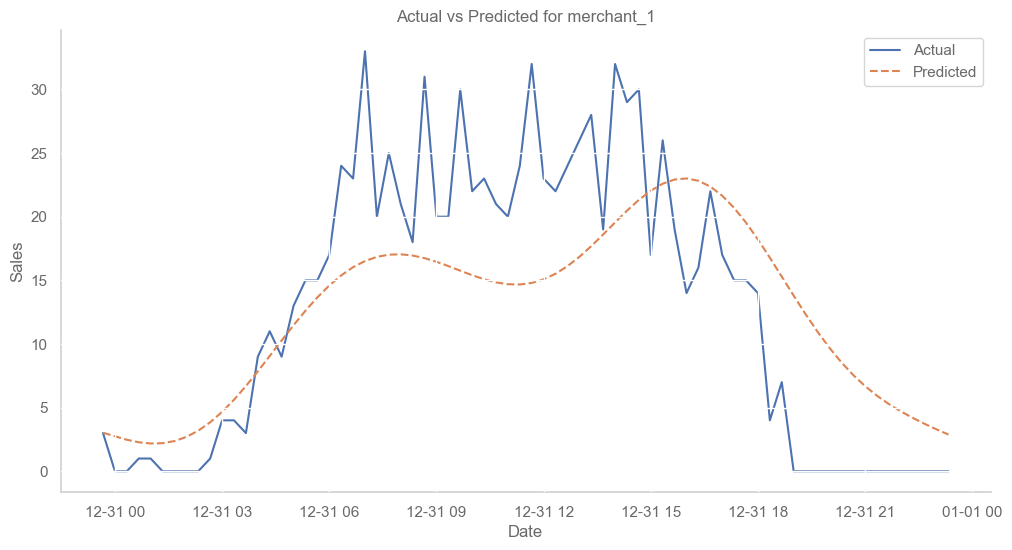

10:18:57 - cmdstanpy - INFO - Chain [1] start processing
10:18:58 - cmdstanpy - INFO - Chain [1] done processing


merchant_10 - RMSE: 7.98, MAE: 5.97


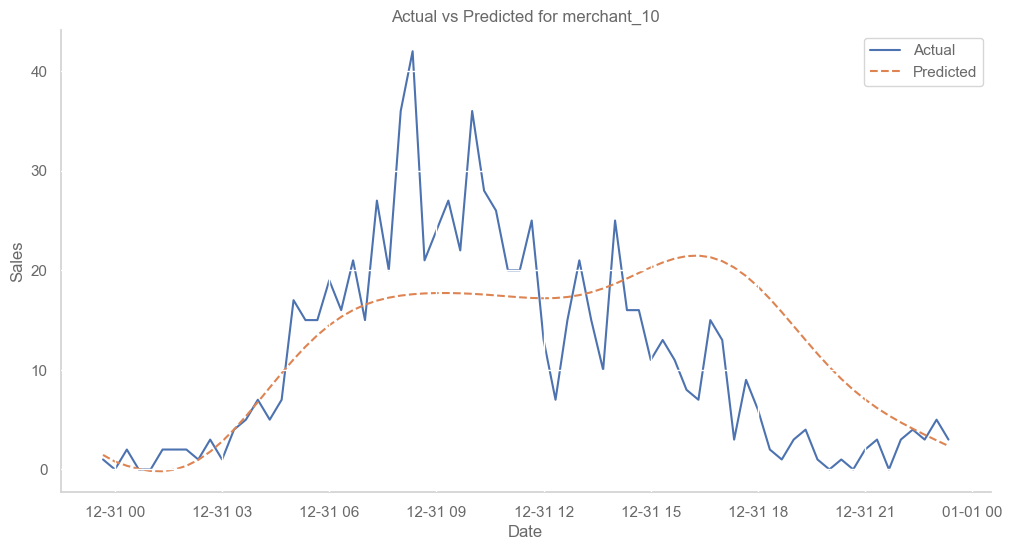

10:18:59 - cmdstanpy - INFO - Chain [1] start processing
10:18:59 - cmdstanpy - INFO - Chain [1] done processing


merchant_2 - RMSE: 5.38, MAE: 4.08


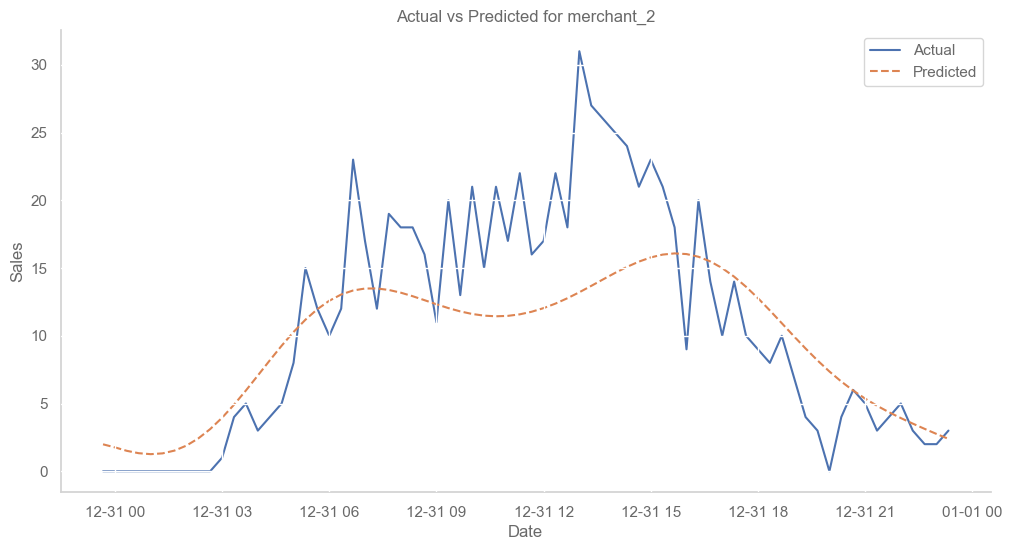

10:19:01 - cmdstanpy - INFO - Chain [1] start processing
10:19:01 - cmdstanpy - INFO - Chain [1] done processing


merchant_3 - RMSE: 3.93, MAE: 3.20


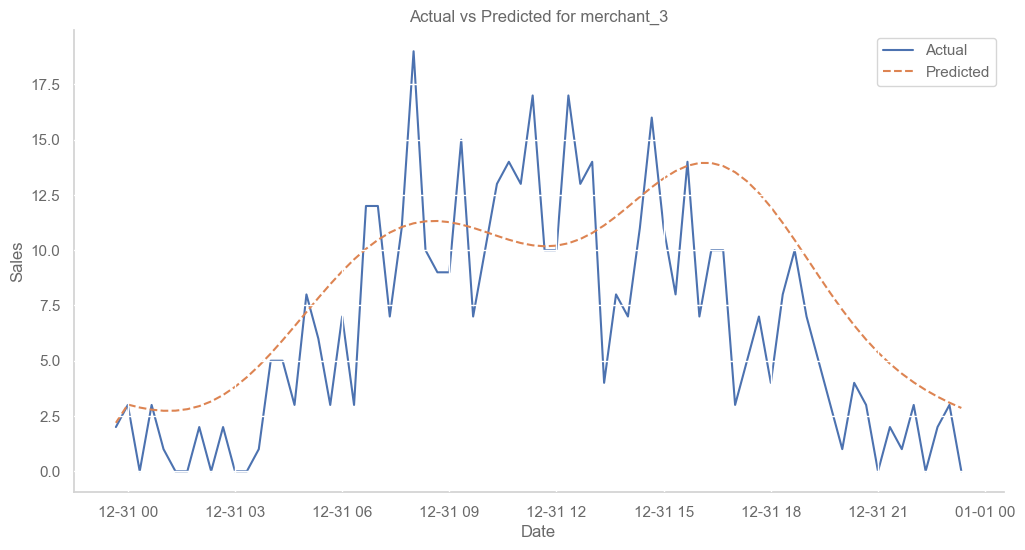

10:19:03 - cmdstanpy - INFO - Chain [1] start processing
10:19:03 - cmdstanpy - INFO - Chain [1] done processing


merchant_4 - RMSE: 6.60, MAE: 4.86


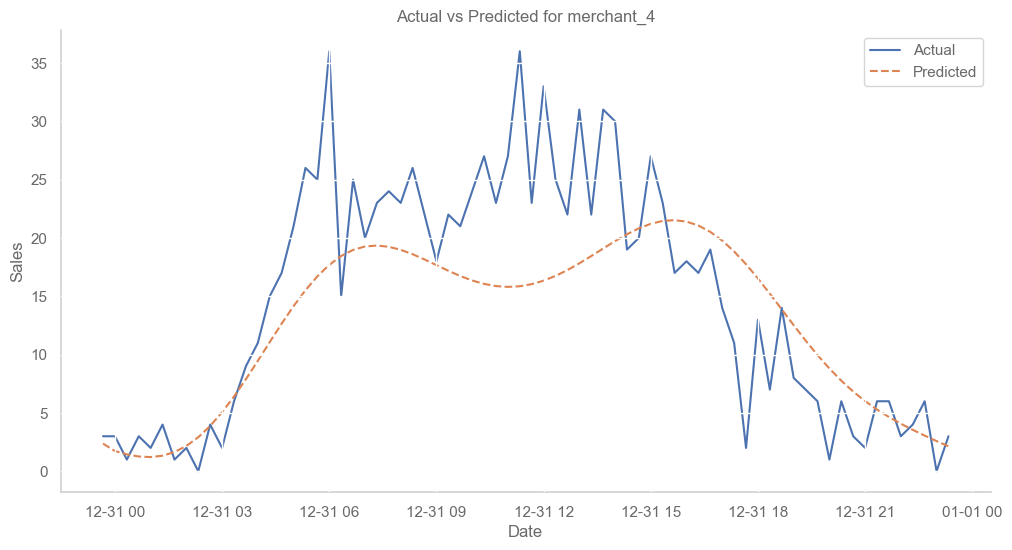

10:19:04 - cmdstanpy - INFO - Chain [1] start processing
10:19:04 - cmdstanpy - INFO - Chain [1] done processing


merchant_5 - RMSE: 6.91, MAE: 5.60


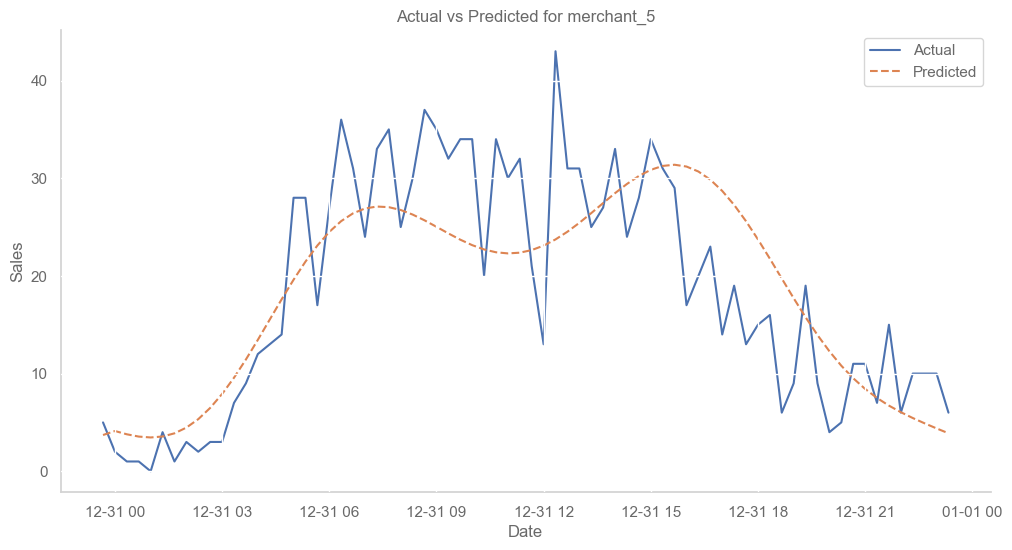

10:19:05 - cmdstanpy - INFO - Chain [1] start processing
10:19:06 - cmdstanpy - INFO - Chain [1] done processing


merchant_6 - RMSE: 3.91, MAE: 3.15


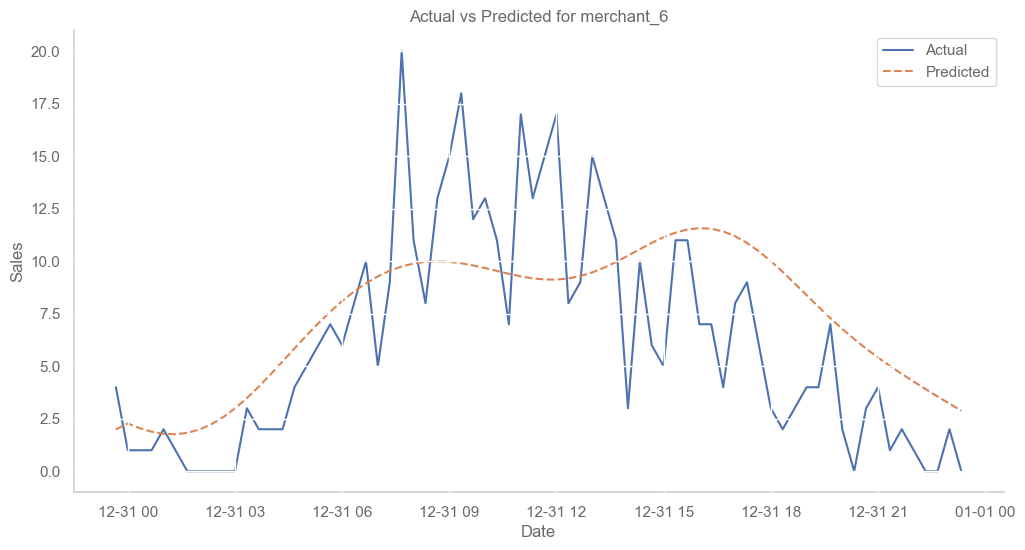

10:19:07 - cmdstanpy - INFO - Chain [1] start processing
10:19:07 - cmdstanpy - INFO - Chain [1] done processing


merchant_7 - RMSE: 4.04, MAE: 3.32


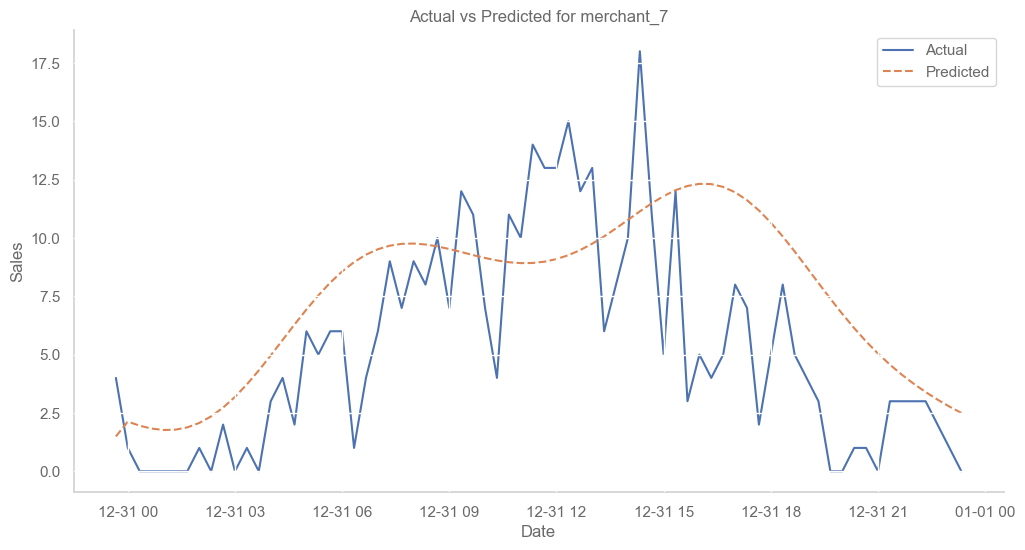

10:19:08 - cmdstanpy - INFO - Chain [1] start processing
10:19:08 - cmdstanpy - INFO - Chain [1] done processing


merchant_8 - RMSE: 10.89, MAE: 9.67


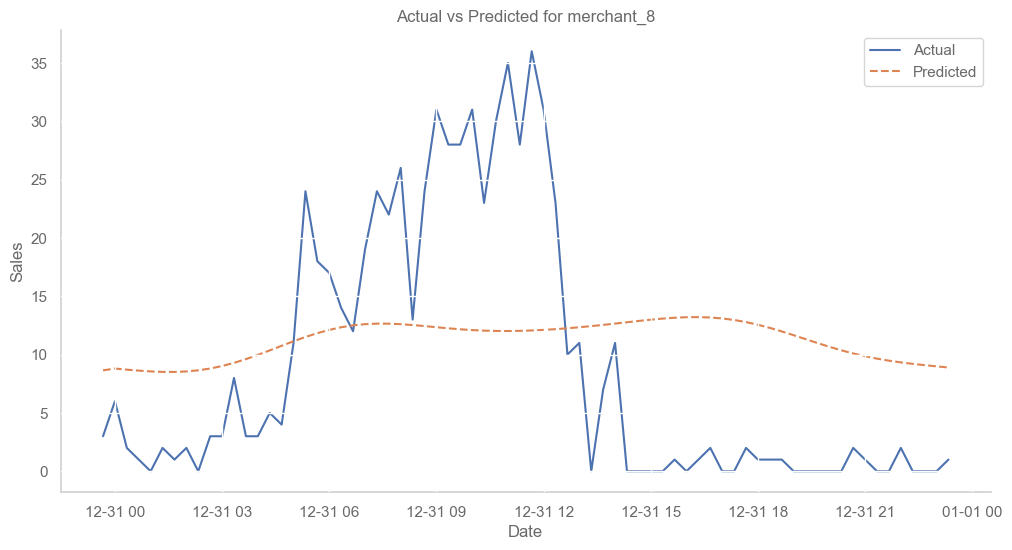

10:19:09 - cmdstanpy - INFO - Chain [1] start processing
10:19:09 - cmdstanpy - INFO - Chain [1] done processing


merchant_9 - RMSE: 5.59, MAE: 4.38


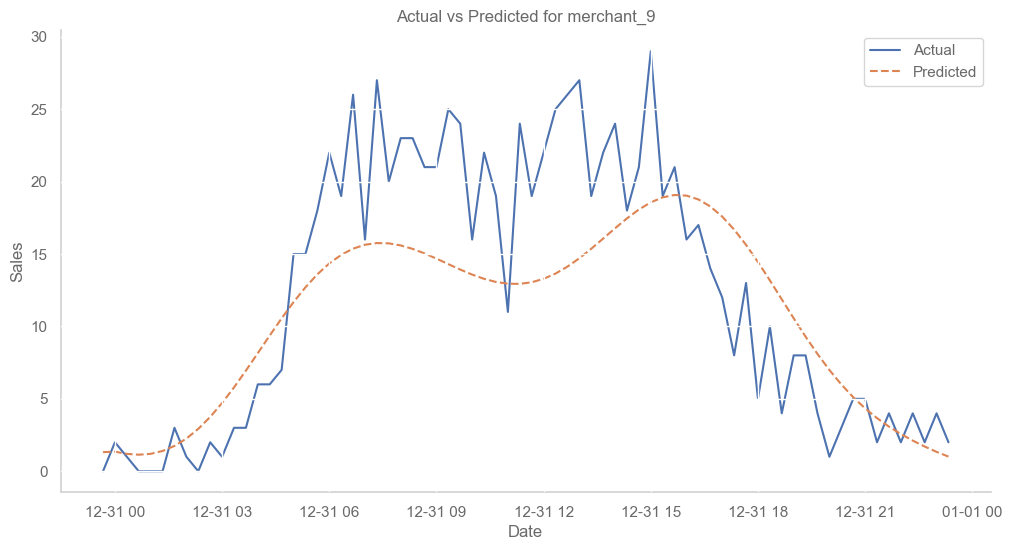

In [28]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_orders_df.columns:
    
    #formatting
    df_copy = total_orders_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                #changepoint_range= len(df_copy/365),
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days * 72, freq='20min')
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds']>=forecast_start_date 
    predicted_df = fcst_prophet_train[filter][['ds','yhat']]
    predicted_df = predicted_df.merge(df_copy)

    #print(feature,mape(predicted_df['y'],predicted_df['yhat']))
    # Calculate RMSE and MAE
    rmse = np.sqrt(np.mean((predicted_df['y'] - predicted_df['yhat'])**2))
    mae = np.mean(np.abs(predicted_df['y'] - predicted_df['yhat']))

    print(f"{feature} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(predicted_df['ds'], predicted_df['y'], label='Actual')
    plt.plot(predicted_df['ds'], predicted_df['yhat'], label='Predicted', linestyle='--')
    plt.title(f'Actual vs Predicted for {feature}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

In [30]:
#total_orders_df.columns

Index(['merchant_1', 'merchant_10', 'merchant_2', 'merchant_3', 'merchant_4',
       'merchant_5', 'merchant_6', 'merchant_7', 'merchant_8', 'merchant_9'],
      dtype='object', name='segment')